In [1]:
# importing packages and modules
import numpy as np
#import autograd.numpy as jnp
import matplotlib as mpl
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1, dglm_hmm2
from scipy.stats import multivariate_normal, norm
#from autograd import value_and_grad

colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen']
colorsStates = ['tab:orange','tab:blue', 'tab:green','tab:red']
myFeatures = [['bias','stimulus', 'previous choice', 'previous reward'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]
sns.set_context("talk")

ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')

In [2]:
# Example subject
subject = 'ibl_witten_15'

In [3]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = [100,10]
maxiter = 300
splitFolds = 5
D = 4 # number of features
sessStop = -1 # last session to use in fitting
K = 3
truepi = np.ones((K))/K

x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=4)
biasedBlockTrials, biasedBlockStartInd, biasedBlockSession, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
N = sessInd[-1]
dGLM_HMM1 = dglm_hmm1.dGLM_HMM1(N,K,D,2)
presentAll = np.ones((N))

Text(762.4583333333334, 0.5, 'Delta Test Ll (per trial)')

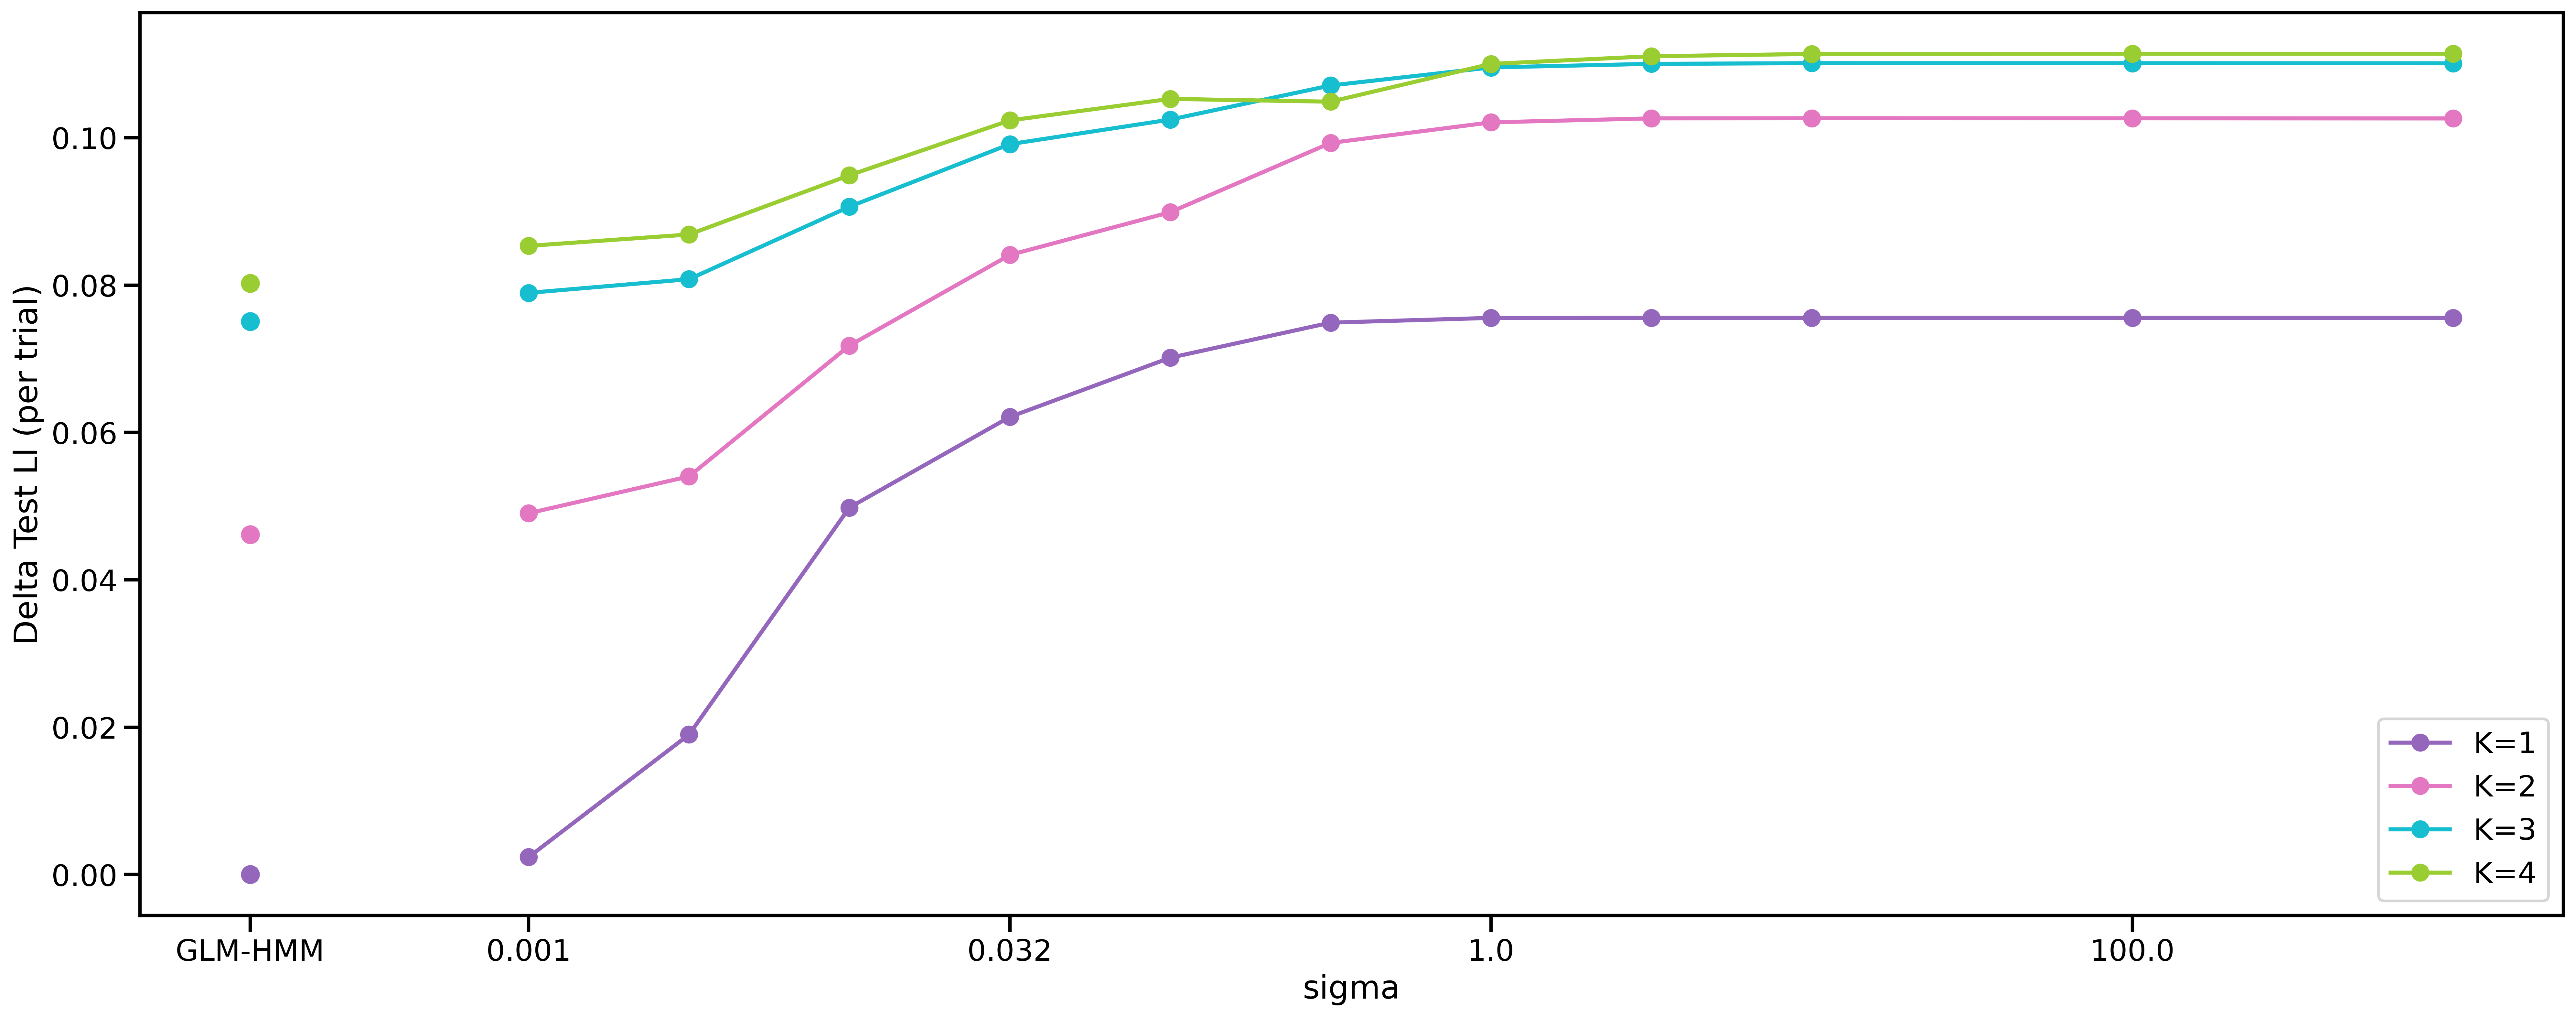

In [4]:
testLlAll = np.empty((4, len(sigmaList)))
bestTestLl = np.zeros((4,11))
bestTestAccuracy = np.zeros((4,11))

testLl = []
testAccuracy = []
avgTestLl = []
avgTestAccuracy = []

for K in [1,2,3,4]:
    data = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}-state_multiple-sigmas_priorDirP={priorDirP}_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
    # fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
    # fig.suptitle(f'{subject}')
    # for fold in range(0, splitFolds):
    #     plot_testLl_CV_sigma(data['testLl'][fold], sigmaList=sigmaList, label=f'K={K} fold {fold}', color=colormap[K-1], axes=axes)
    avgTestLl.append(np.mean(data['testLl'],axis=0))
    avgTestAccuracy.append(np.mean(data['testAccuracy'],axis=0))
avgTestLl = [x - avgTestLl[0][0] for x in avgTestLl] # normalizing to GLM-HMM sigma=0 K=1
avgTestAccuracy = [x - avgTestAccuracy[0][0] for x in avgTestAccuracy]
    
bestSigmaInd = 7 # Choosing best sigma index across animals
for K in [1,2,3,4]:
    bestTestLl[K-1] = avgTestLl[K-1][bestSigmaInd] - avgTestLl[0][bestSigmaInd] # delta
    bestTestAccuracy[K-1] = avgTestAccuracy[K-1][bestSigmaInd] - avgTestAccuracy[0][bestSigmaInd] # delta

# # Plotting each fold indiviudally for per-animal plots
# fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
# fig.suptitle(f'{subject}')
# for K in range(1,5):
#     for fold in range(0, splitFolds):
#         plot_testLl_CV_sigma(testLl[splitFolds*(K-1)+fold], sigmaList=sigmaList, label=f'K={K} fold {fold}', color=colormap[K-1], axes=axes)
    
# Plotting delta test ll averaged across folds for per-animal plots
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
fig.tight_layout()
for K in range(1,5):
    plot_testLl_CV_sigma(avgTestLl[K-1], sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes)
axes.set_ylabel("Delta Test Ll (per trial)")

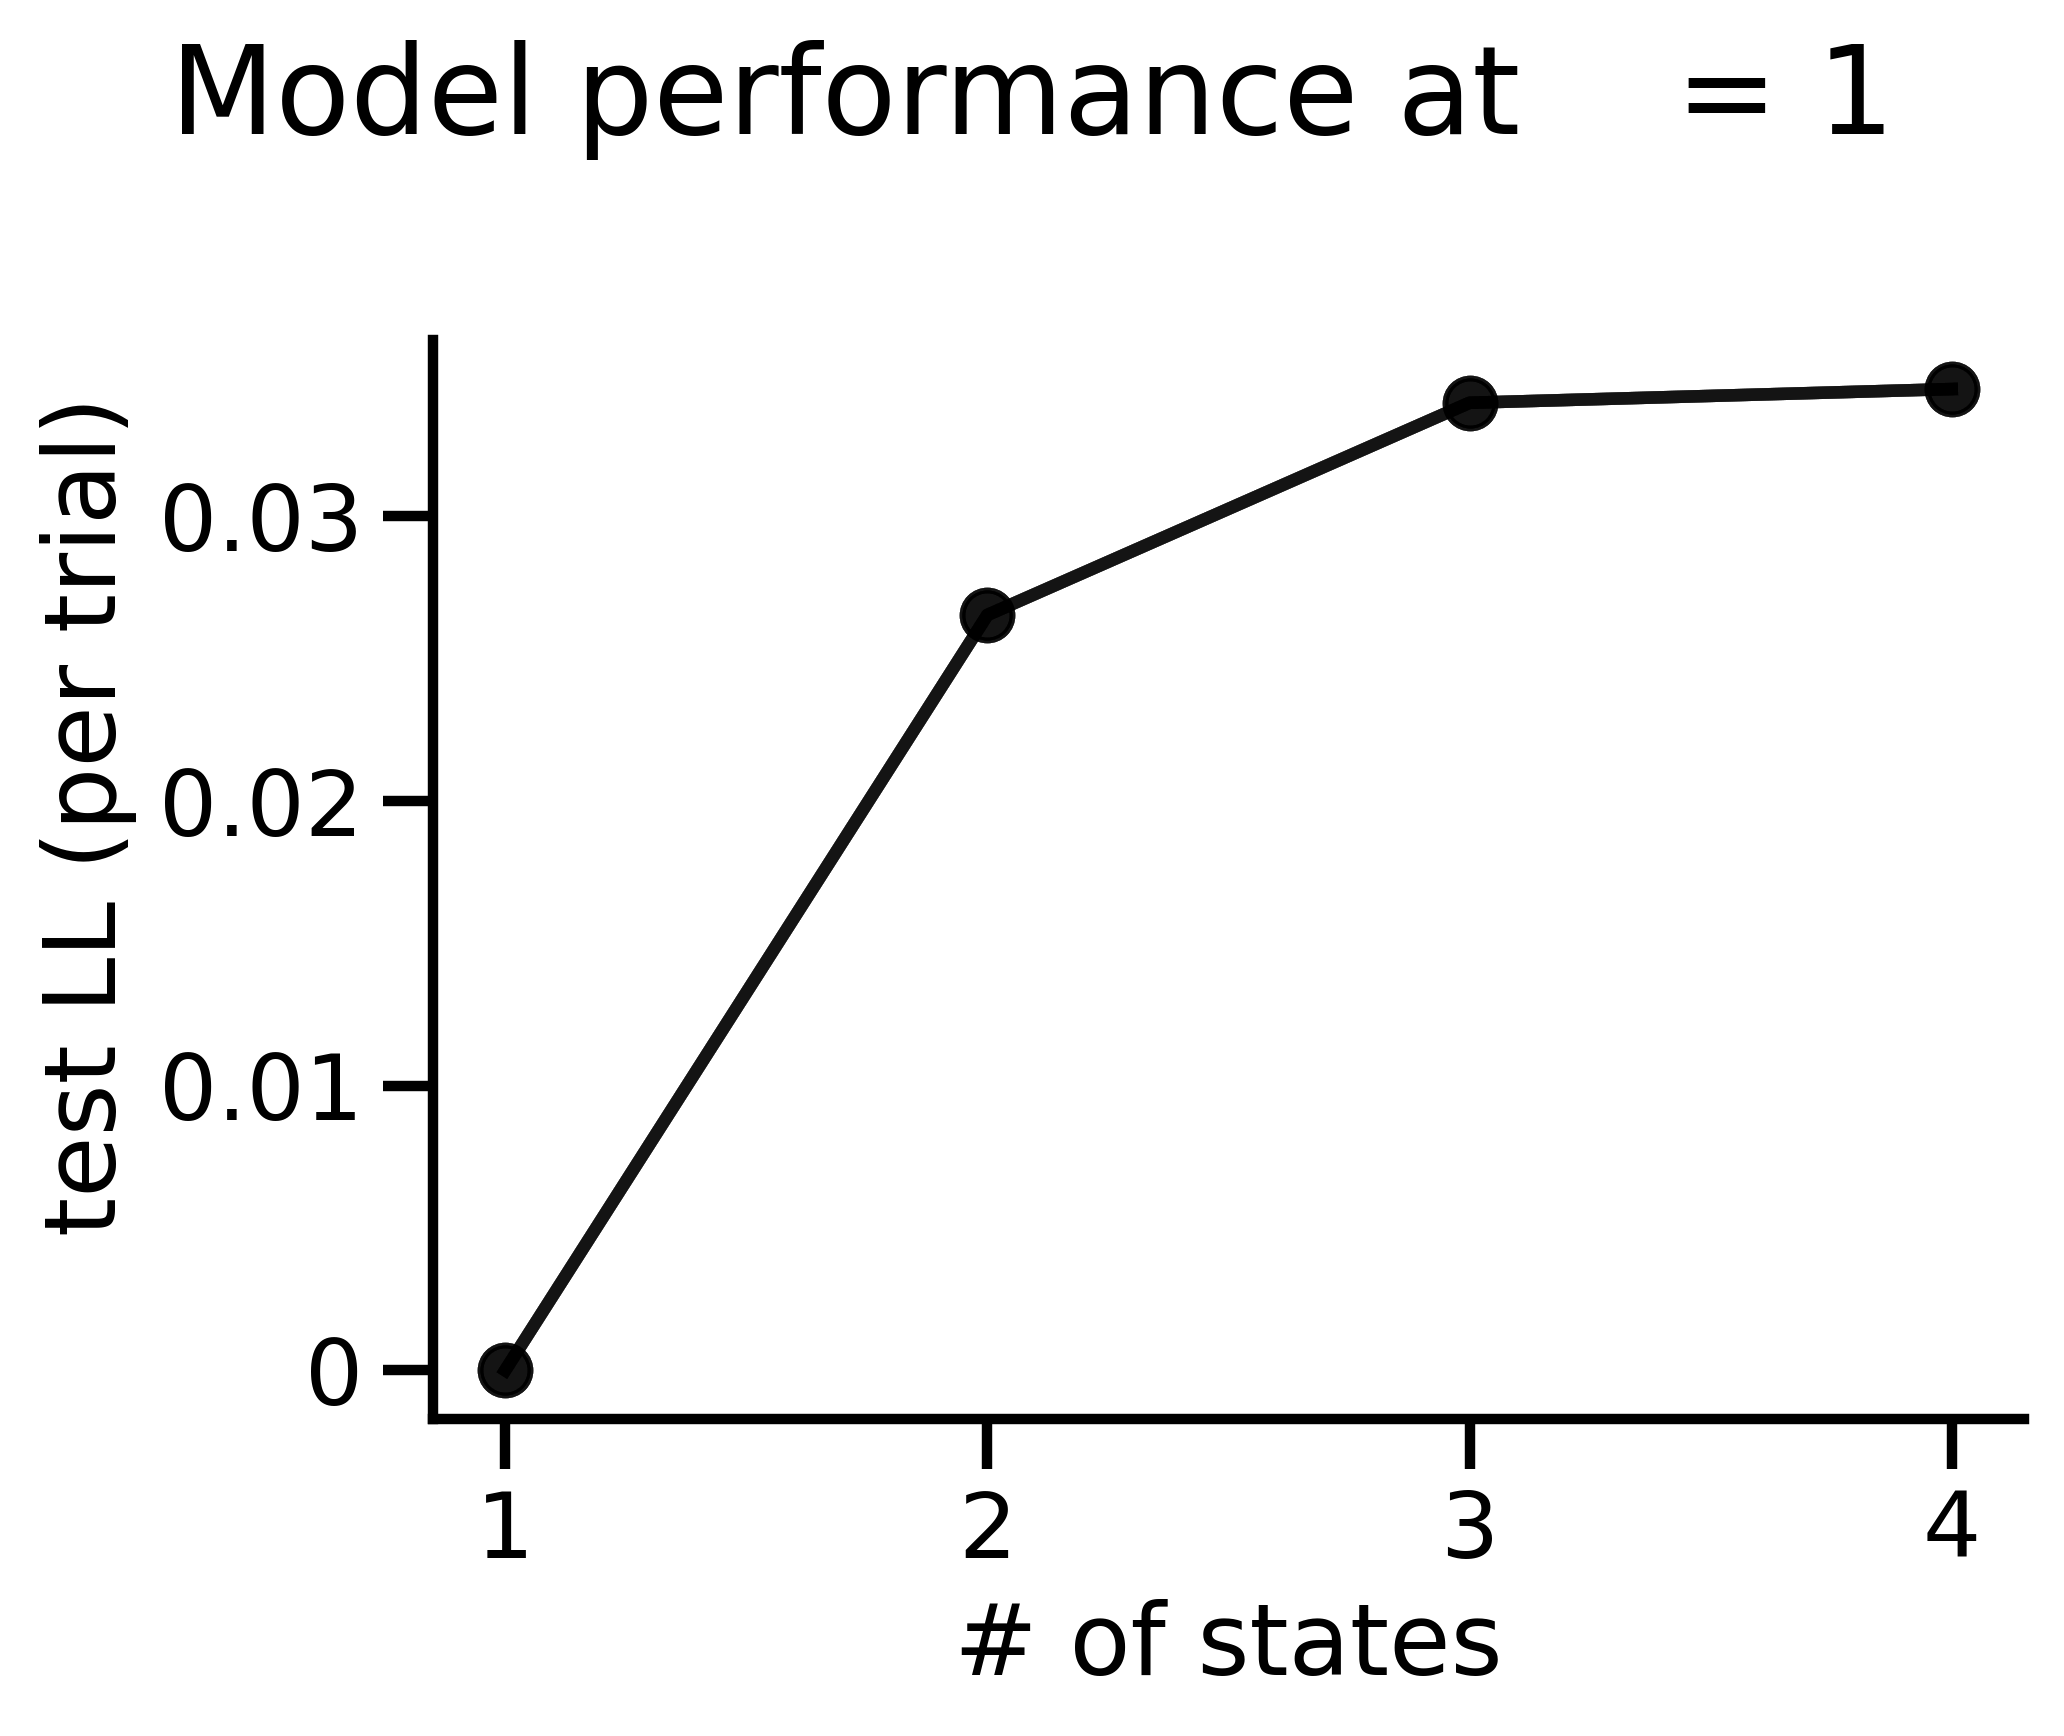

In [5]:
fig, axes = plt.subplots(1, figsize=(5.5,4.5), dpi=400)
axes.plot([1,2,3,4],bestTestLl[:],'-o', color='black',alpha=0.2)
axes.set_xticks([1,2,3,4])
axes.set_yticks([0,0.01,0.02,0.03],[0,0.01,0.02,0.03])
axes.set_xlabel('# of states')
axes.set_ylabel('    test LL (per trial)')
axes.spines[['right', 'top']].set_visible(False)
fig.suptitle('Model performance at    = 1', size=22)
fig.tight_layout()
plt.savefig(f'../figures/TestLl_vs_K_sigma=1_{subject}.png', bbox_inches='tight', dpi=400)

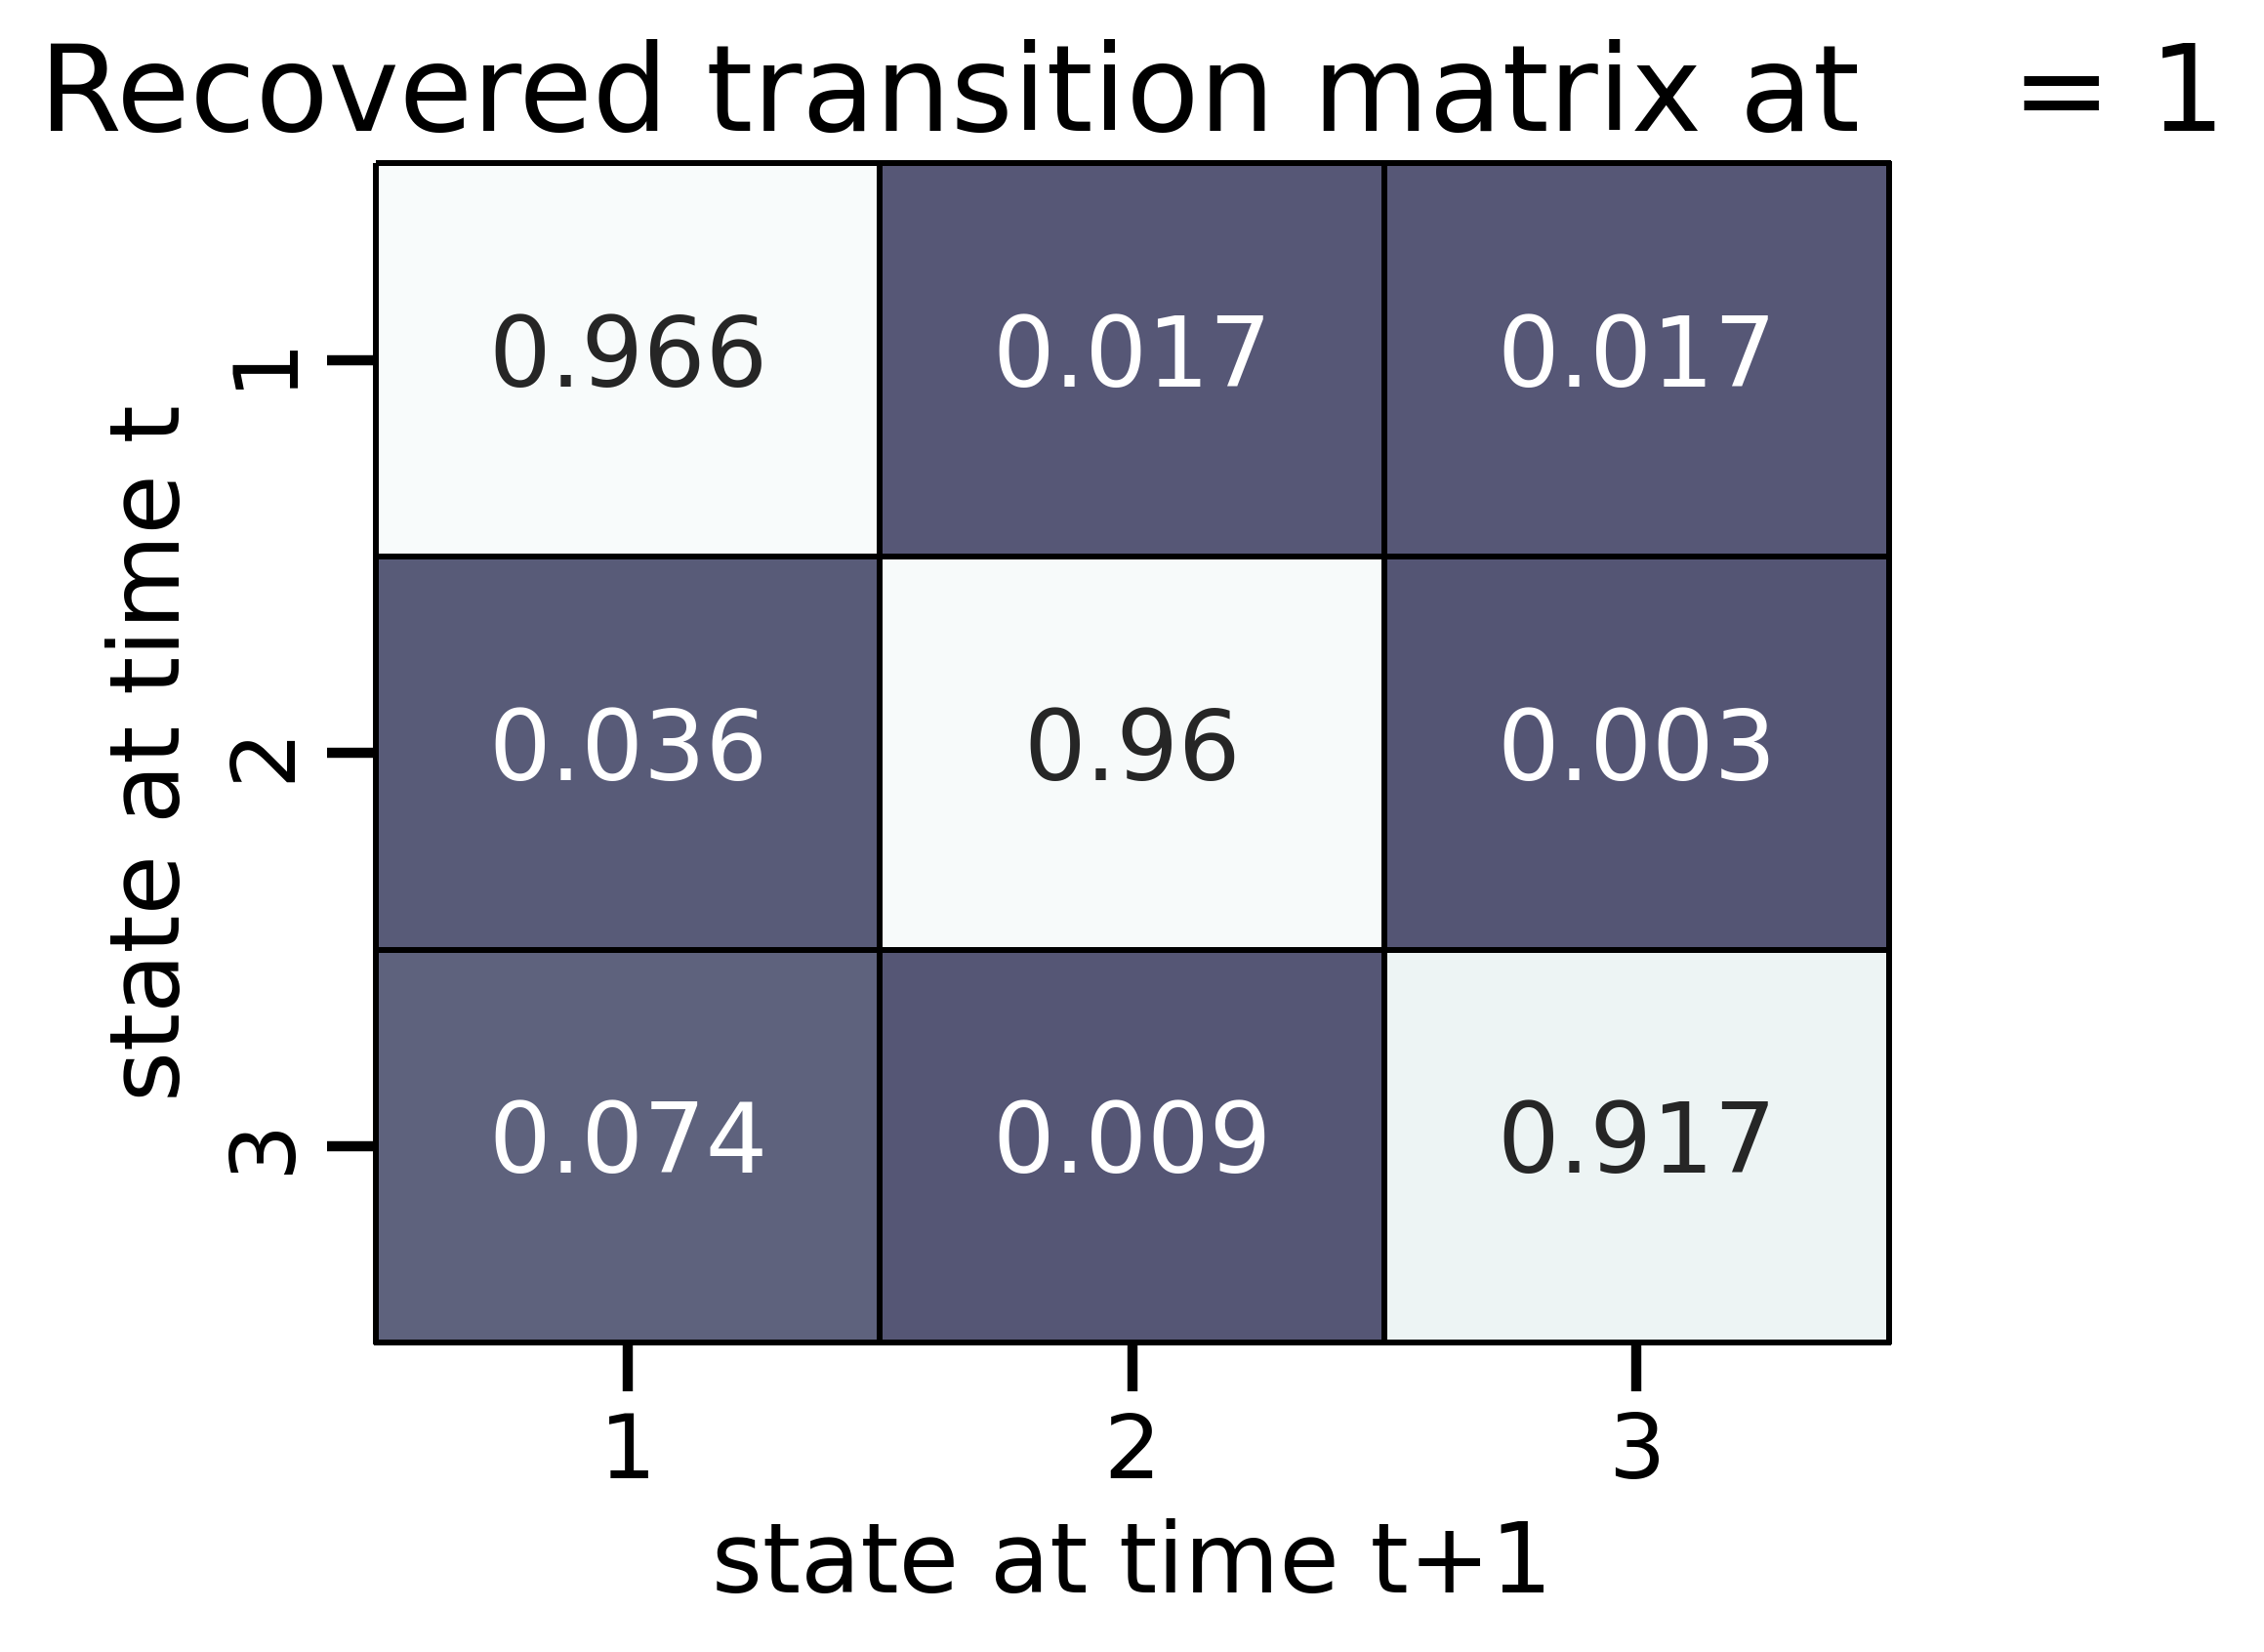

In [6]:
# Plotting Weights
K = 3
sessionsInterest = [7,15,30]
bestSigmaInd = 7

sns.set_context("talk")
myFeatures = [['bias','stimulus', 'previous choice', 'previous reward'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]
K = 3
data = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}-state_multiple-sigmas_priorDirP={priorDirP}_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
        
# for fold in range(0, splitFolds):
#     tempP.append(data['allP'][fold])
#     tempW.append(data['allW'][fold])
            
    # # plotting transition matrix individually 
    # fig, axes = plt.subplots()
    # plot_transition_matrix(tempP[fold][bestSigmaInd], sortedStateInd=None) # not sorted

    # # plotting weights for each fold individually
    # fig, axes = plt.subplots(D, 1,figsize=(16,4*D+1), sharex=True)
    # fig.suptitle(f'{subject}: sigma = {np.round(sigmaList[bestSigmaInd],2)} fold {fold}')
    # fig.tight_layout()
    # plotting_weights_per_feature(tempW[fold][bestSigmaInd], sessInd, axes, yLim=[[-2.5,2.5],[-6.2,6.2]], colors=colorsStates, labels=myFeatures[D%2], linewidth=5, linestyle='-', sortedStateInd=None)
        
allP1 = np.mean(data['allP'], axis=0)
allW1 = np.mean(data['allW'], axis=0) 

# computing gamma for bestSigmaInd
gamma_old = dGLM_HMM1.get_posterior_latent(allP1[bestSigmaInd], truepi, allW1[bestSigmaInd], x, y, presentAll, sessInd, sortedStateInd=None)

# plotting transition matrix averaged across folds
plot_transition_matrix(np.round(allP1[bestSigmaInd],3), title=f'', sortedStateInd=None) # not sorted
plt.title('Recovered transition matrix at    = 1', size=22)
plt.savefig(f'../figures/RecoveredP_2-state_sigma=1_{subject}.png', bbox_inches='tight', dpi=400)
            
# plotSess = len(sessInd)-1 #min(len(sessInd)-1)#,50)
# fig, axes = plt.subplots(D, 1,figsize=(16,16), sharex=True)#, dpi=400)
# fig.tight_layout()
# yLim=[[-2.7,2.7],[-0.5,8.2],[-2.7,2.7],[-2.7,2.7]]
# for d in range(0, 2):
#     axes[d].axhline(0, alpha=0.2, color='black',linestyle='-')
#     for k in range(0, K):
#         axes[d].plot(range(1,plotSess+1),-allW1[0][sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=3, alpha=1, linestyle='--', label='constant', zorder=1)
#         axes[d].plot(range(1,plotSess+1),-allW1[bestSigmaInd][sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=5, alpha=1, linestyle='-', label='dynamic', zorder=0)
#         # for s in sessionsInterest:
#         #     axes[d].scatter(s+1, -avgW[bestSigmaInd][sessInd[s],k,d,1], color='black', zorder=2)
#     lines = axes[d].get_lines()
#     include = [1,2]
#     legend1 = axes[d].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.85), title = "State 1")
#     include = [3,4]
#     legend2 = axes[d].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.5), title = "State 2")
#     include = [5,6]
#     legend3 = axes[d].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.15), title = "State 3")
#     axes[d].add_artist(legend1)
#     axes[d].add_artist(legend2)
#     axes[d].add_artist(legend3)
#     axes[d].set_ylim(yLim[1-d])
#     # axes[d].set_title(f'{myFeatures[D%2][d]}')
#     axes[d].set_ylabel(f'weights')
#     axes[d].set_title(f'{myFeatures[D%2][1-d]} weights', size=22)
#     axes[d].spines[['right', 'top']].set_visible(False)
# for d in range(2, D):
#     axes[d].axhline(0, alpha=0.2, color='black',linestyle='-')
#     for k in range(0, K):
#         axes[d].plot(range(1,plotSess+1),-allW1[0][sessInd[:plotSess],k,d,1],color=colorsStates[k],linewidth=3, alpha=1, linestyle='--', label='   =0', zorder=1)
#         axes[d].plot(range(1,plotSess+1),-allW1[bestSigmaInd][sessInd[:plotSess],k,d,1],color=colorsStates[k],linewidth=5, alpha=1, linestyle='-', label='   =1', zorder=0)
#         # for s in sessionsInterest:
#         #     axes[d].scatter(s+1, -avgW[bestSigmaInd][sessInd[s],k,d,1], color='black', zorder=2)
#     axes[d].set_ylim(yLim[d])
#     # axes[d].set_title(f'{myFeatures[D%2][d]}')
#     axes[d].set_ylabel(f'weights')
#     axes[d].set_title(f'{myFeatures[D%2][1-d]} weights', size=22)
#     axes[d].spines[['right', 'top']].set_visible(False)
# lines = axes[0].get_lines()
# include = [1,2]
# legend1 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.85), title = "State 1")
# include = [3,4]
# legend2 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.5), title = "State 2")
# include = [5,6]
# legend3 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.15), title = "State 3")
# axes[0].add_artist(legend1)
# axes[0].add_artist(legend2)
# axes[0].add_artist(legend3)
# axes[3].set_xlabel('session')

In [7]:
# TRY CORRELATE ALIGNMENT OF BIAS WITH TASK PERFORMANCE OF ANIMAL!!!

# Look at model's performance if stimulus weights are ???

In [8]:
# Average latents across right blocks aligned?

### Varying transition matrix P

In [9]:
# setting hyperparameters
L2penaltyW = 1
maxiter = 200
bestSigma = 1 # verified from fitting multiple sigmas
priorDirP = [100,10]
fit_init_states = False
D = 4 # number of features
sessStop = -1 # last session to use in fitting
bestAlpha = 2 # found by cross-validation
K = 3
inits = 21

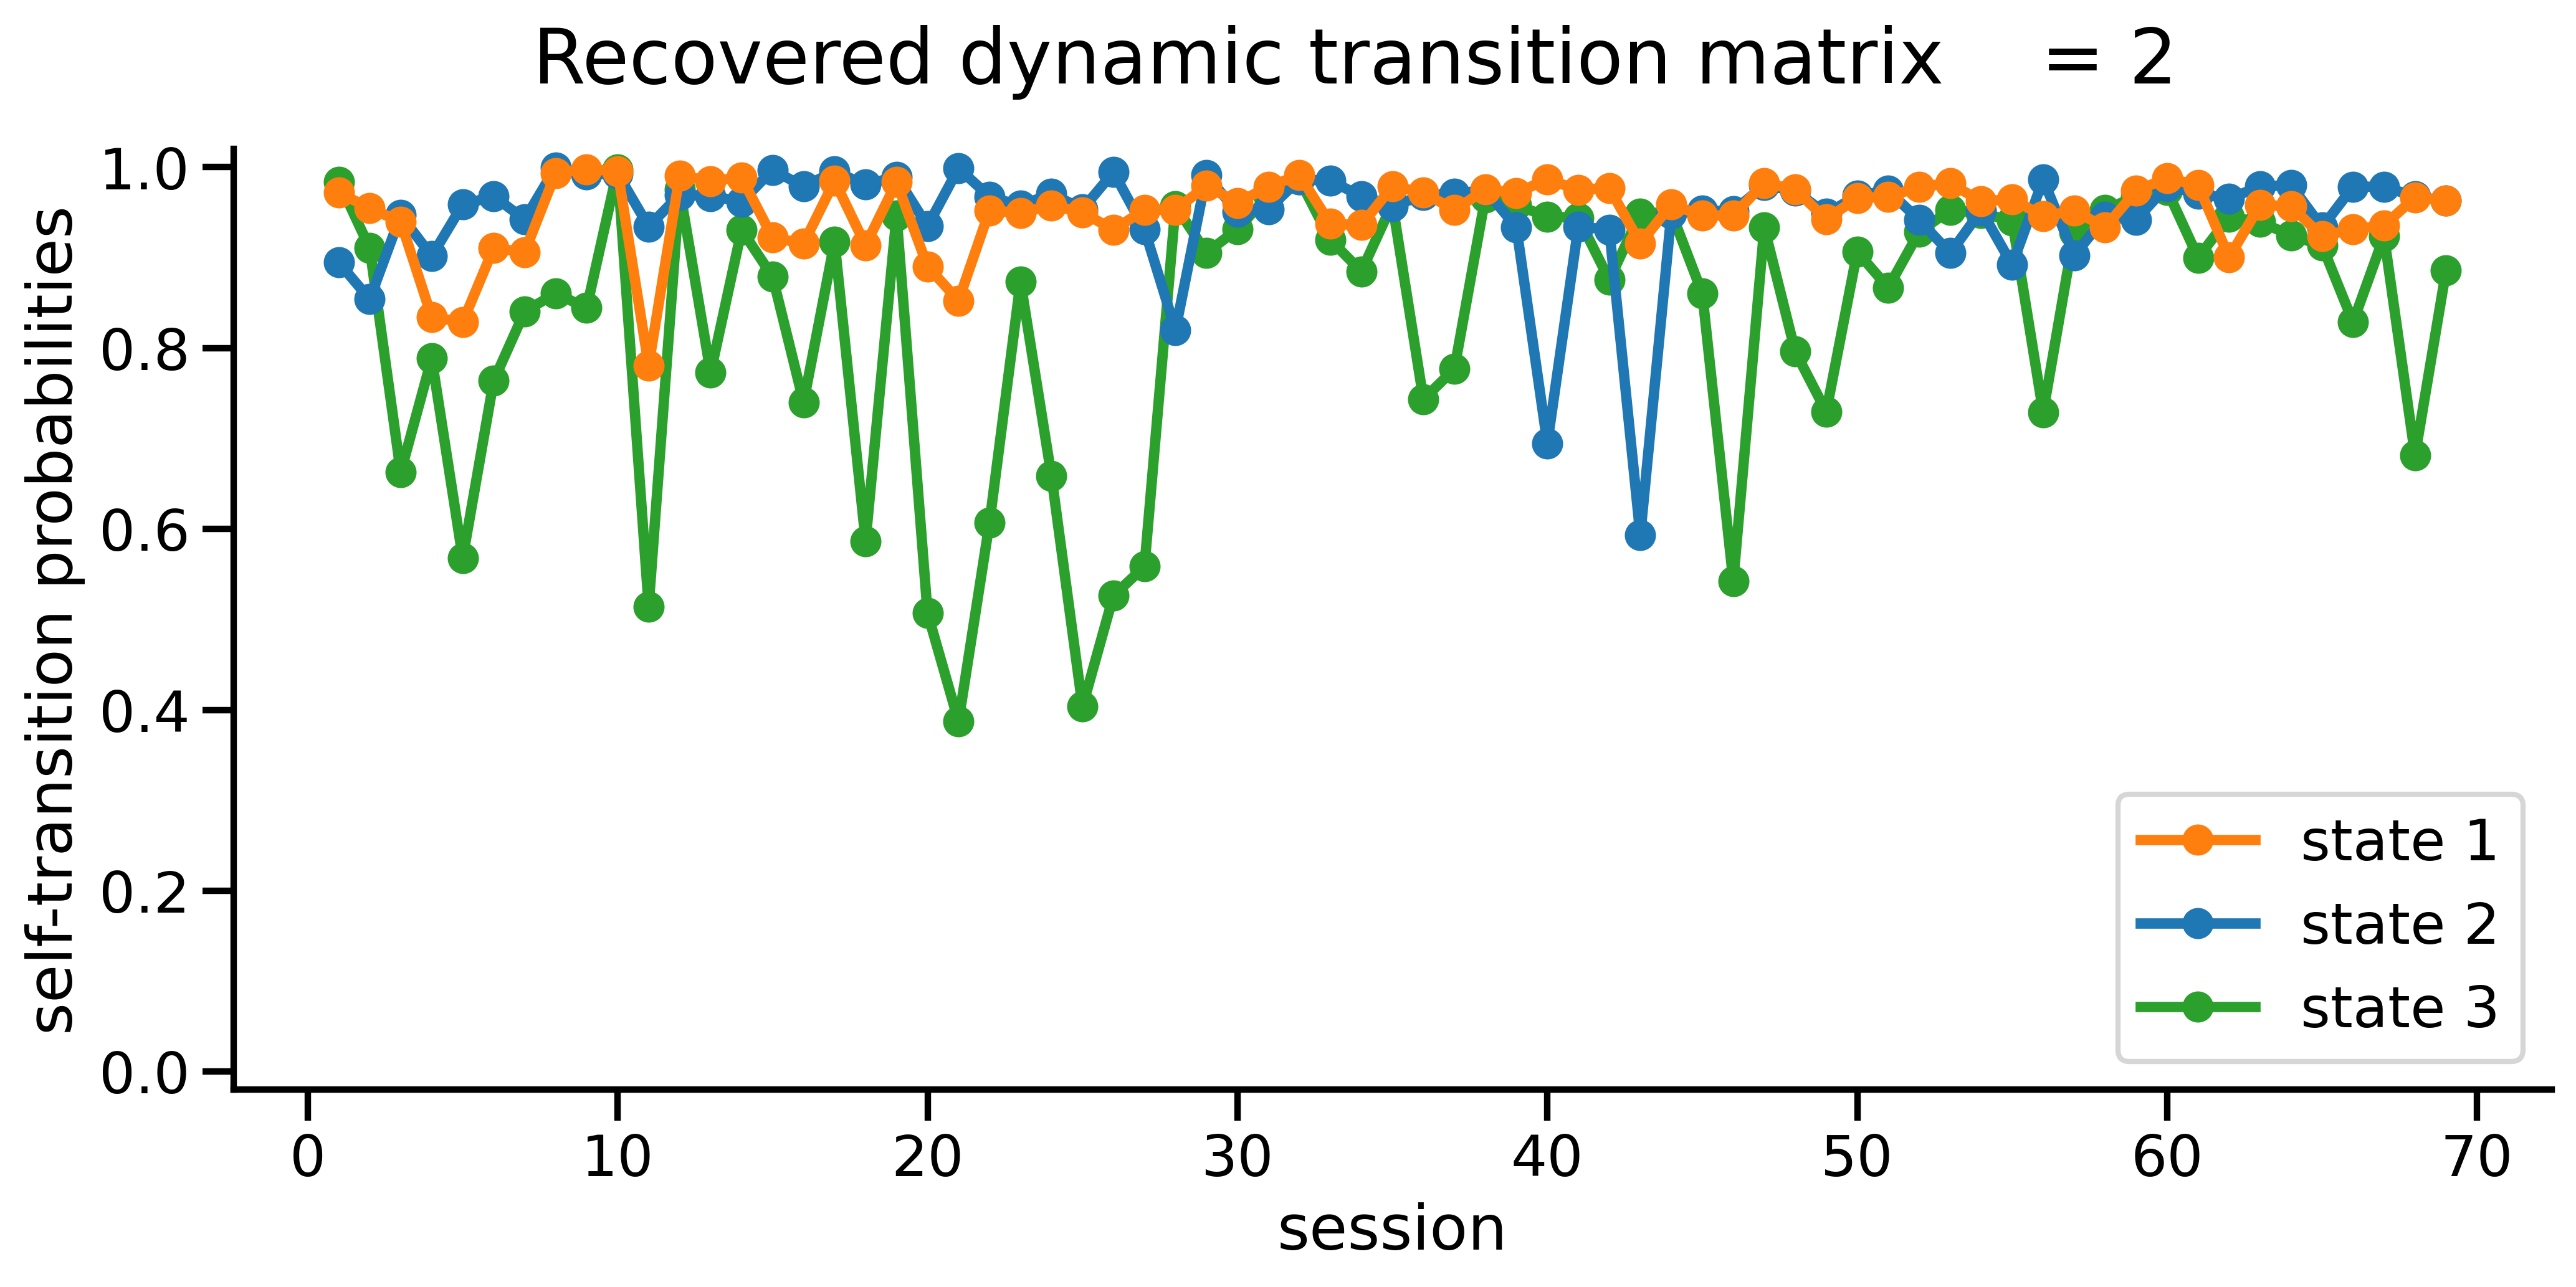

In [10]:
_, _, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
param = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}_state_alpha={bestAlpha}_multiple-initsP_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
allP =  param['allP'][0] # starting from best dGLMHMM1 fit
allW =  param['allW'][0] # starting from best dGLMHMM1 fit
 
fig, axes = plt.subplots(1, figsize = (12,5), dpi=400) # for poster
sess = len(sessInd)-1
for i in range(0,allP.shape[1]):
    axes.plot(range(1,sess+1),allP[sessInd[:-1],i,i],'-o', linewidth=3, color=colorsStates[i], label=f'state {i+1}', zorder=allP.shape[1]-i, markersize=8)
    # axes.scatter(range(1,sess+1),allP[sessInd[:-1],i,i],'-', color=colorsStates[i], label=f'state {i+1}', zorder=allP.shape[1]-i)
        
axes.set_ylabel("self-transition probabilities")
axes.set_ylim(0.6,1)
axes.set_xlabel('session')
# plotting_self_transition_probabilities(allP, sessInd, axes, title='', linewidth=3, save_fig=False, sortedStateInd=None, colorsStates=colorsStates)
axes.spines[['right', 'top']].set_visible(False)
# axes.set_title(f'Recovered    =100 vs true transition matrix', fontsize=25)
axes.legend(loc = 'lower right')
fig.suptitle('Recovered dynamic transition matrix    = 2', size=22)
axes.set_ylim(-0.02,1.02)
plt.savefig(f'../figures/Self-transition_probabilties-alpha={bestAlpha}_{subject}.png', bbox_inches='tight', dpi=400)
        

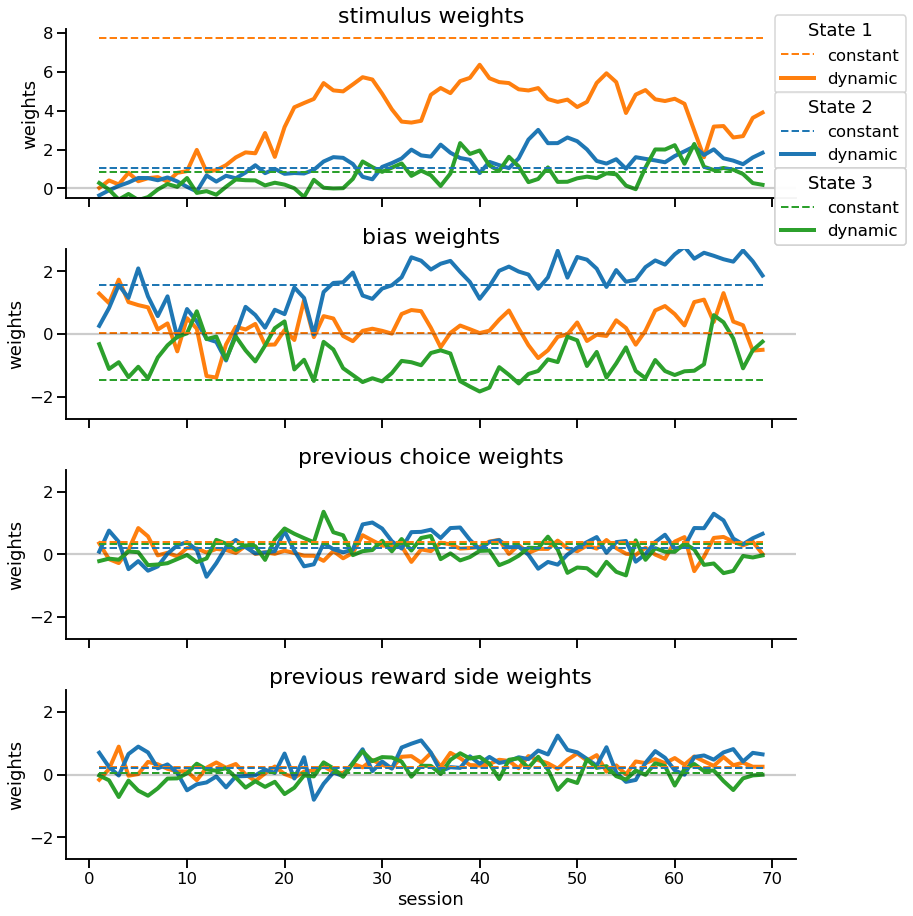

In [11]:
# Plotting Weights
K = 3
bestSigmaInd = 7
sns.set_context("talk")
myFeatures = [['bias','stimulus', 'previous choice', 'previous reward side'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]
K = 3
data = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}-state_multiple-sigmas_priorDirP={priorDirP}_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz') 
allP1 = np.mean(data['allP'], axis=0)
allW1 = np.mean(data['allW'], axis=0)    

# computing gamma for bestSigmaInd
dGLM_HMM = dglm_hmm2.dGLM_HMM2(N,K,D,2)
gamma = dGLM_HMM.get_posterior_latent(allP, truepi, allW, x, y, presentAll, sessInd, sortedStateInd=None)
phi = dGLM_HMM.observation_probability(x, allW)
   
plotSess = len(sessInd)-1 #min(len(sessInd)-1)#,50)
fig, axes = plt.subplots(D, 1,figsize=(12,13), sharex=True)#, dpi=400)
fig.tight_layout(pad=2)
yLim=[[-2.7,2.7],[-0.5,8.2],[-2.7,2.7],[-2.7,2.7]]
for d in range(0, 2):
    axes[d].axhline(0, alpha=0.2, color='black',linestyle='-')
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),-allW1[0][sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=2, alpha=1, linestyle='--', label='constant', zorder=1)
        axes[d].plot(range(1,plotSess+1),-allW[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=4, alpha=1, linestyle='-', label='dynamic', zorder=0)
        # for s in sessionsInterest:
        #     axes[d].scatter(s+1, -avgW[bestSigmaInd][sessInd[s],k,d,1], color='black', zorder=2)
    axes[d].set_ylim(yLim[1-d])
    # axes[d].set_title(f'{myFeatures[D%2][d]}')
    axes[d].set_ylabel(f'weights')
    axes[d].set_title(f'{myFeatures[D%2][1-d]} weights', size=22)
    axes[d].spines[['right', 'top']].set_visible(False)
for d in range(2, D):
    axes[d].axhline(0, alpha=0.2, color='black',linestyle='-')
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),-allW1[0][sessInd[:plotSess],k,d,1],color=colorsStates[k],linewidth=2, alpha=1, linestyle='--', label='   =0', zorder=1)
        axes[d].plot(range(1,plotSess+1),-allW[sessInd[:plotSess],k,d,1],color=colorsStates[k],linewidth=4, alpha=1, linestyle='-', label='   =1', zorder=0)
        # for s in sessionsInterest:
        #     axes[d].scatter(s+1, -avgW[bestSigmaInd][sessInd[s],k,d,1], color='black', zorder=2)
    axes[d].set_ylim(yLim[d])
    # axes[d].set_title(f'{myFeatures[D%2][d]}')
    axes[d].set_ylabel(f'weights')
    axes[d].set_title(f'{myFeatures[D%2][d]} weights', size=22)
    axes[d].spines[['right', 'top']].set_visible(False)
lines = axes[0].get_lines()
include = [1,2]
legend1 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.96, 0.85), title = "State 1")
include = [3,4]
legend2 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.96, 0.4), title = "State 2")
include = [5,6]
legend3 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.96, -0.05), title = "State 3")
axes[0].add_artist(legend1)
axes[0].add_artist(legend2)
axes[0].add_artist(legend3)
axes[3].set_xlabel('session')
plt.savefig(f'../figures/weights_sigma=1_{subject}.png', bbox_inches='tight', dpi=400)

In [12]:
def soft_occupancy_states_sessions(gamma, sessInd):
    K = gamma.shape[1]
    p_occ_states_sessions = np.zeros((len(sessInd)-1, K))
    for session in range(0, len(sessInd)-1):
        for k in range(0,K):
            p_occ_states_sessions[session, k] = np.mean(gamma[sessInd[session]:sessInd[session+1], k])    
   
    return p_occ_states_sessions

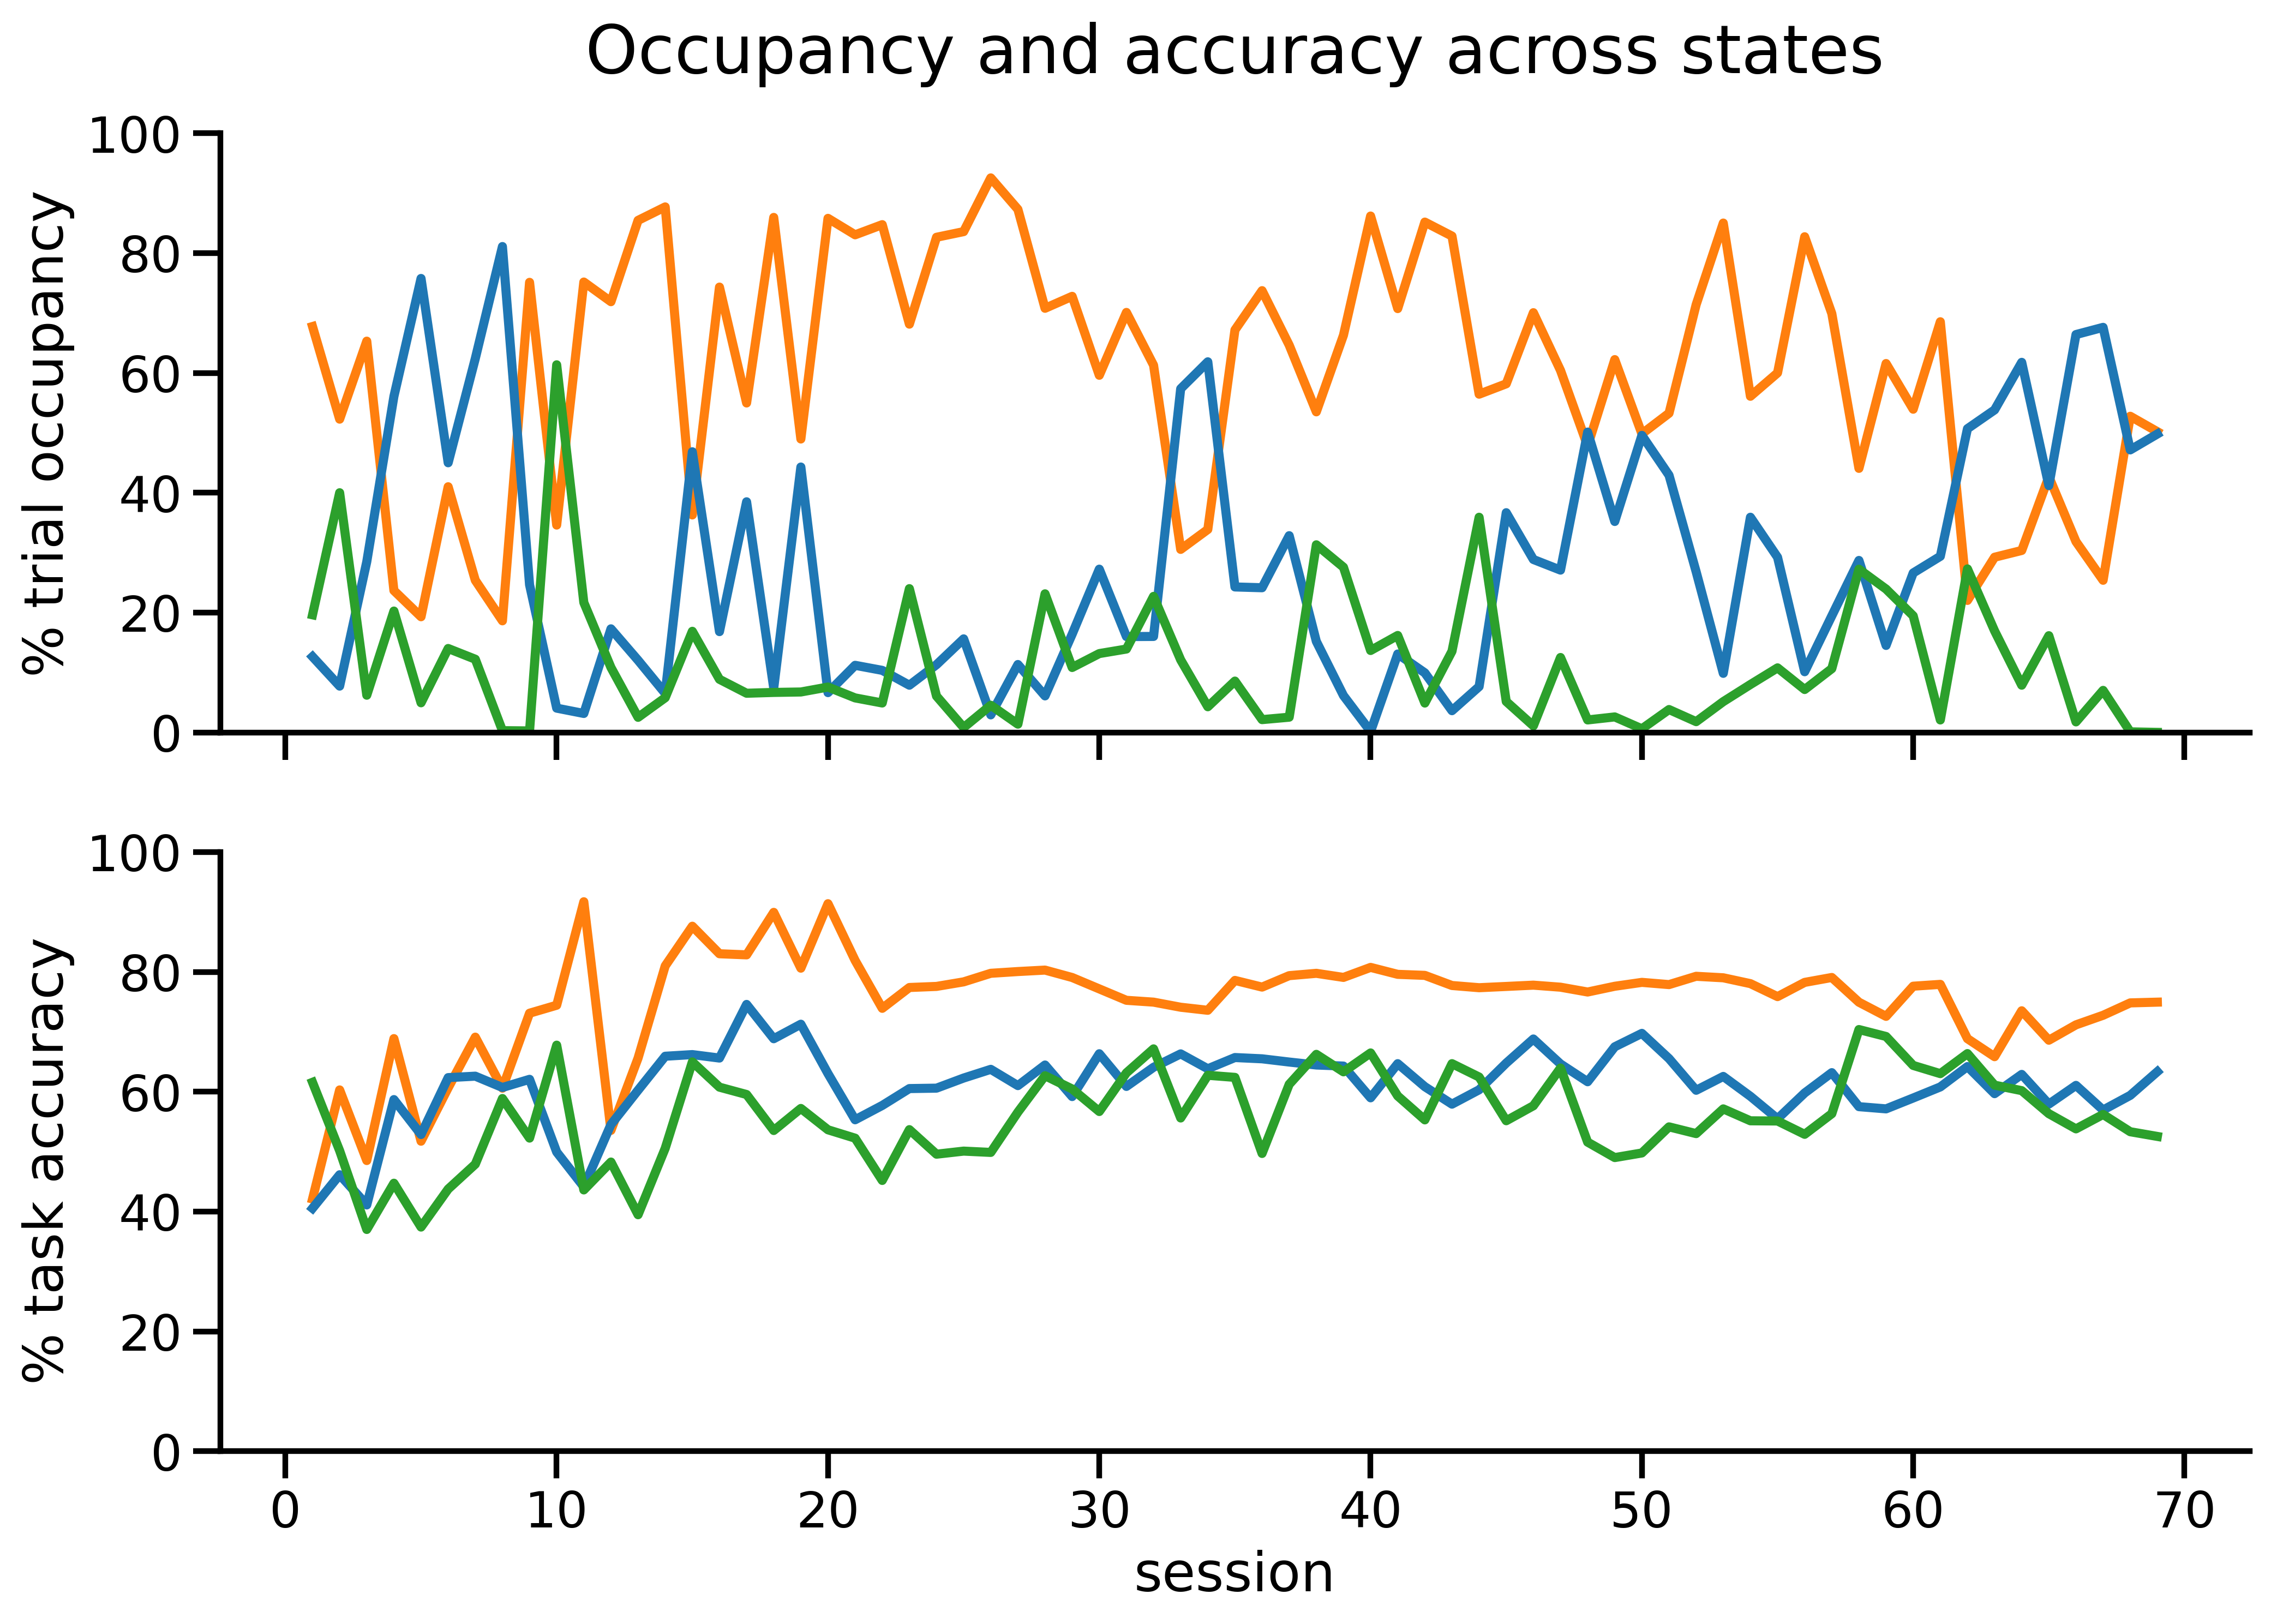

In [13]:
# Plotting task occupancy of each state across sessions
fig, axes = plt.subplots(2, figsize = (12,8), sharex=True, dpi=400) 
_ = plot_state_occupancy_sessions(gamma, sessInd, axes[0], colors=colorsStates, linewidth=3)
axes[0].set_xlabel('')

# other way of computing occupancies
# p_occ_states_sessions = soft_occupancy_states_sessions(gamma, sessInd)
# for k in range(0,K):
#     axes[0].plot(range(1,len(sessInd)), p_occ_states_sessions[:,k], color=colorsStates[k], linewidth=3, label=f'state {k+1}')

# plotting task accuracy in each state across sessions
p_correct, p_correct_states, p_correct_sessions, p_correct_states_sessions = accuracy_states_sessions(gamma, phi, y, correctSide, sessInd)

for k in range(0,K):
    axes[1].plot(range(1,len(sessInd)), p_correct_states_sessions[:,k], color=colorsStates[k], linewidth=3, label=f'state {k+1}')
    # axes[1].plot(range(1,len(sessInd)), p_correct_sessions, color='black', linewidth=3)
axes[1].set_ylim(0,100)
axes[1].set_ylabel('% task accuracy ')
axes[1].set_xlabel('session')
axes[1].legend(loc='lower right')

axes[0].spines[['right', 'top']].set_visible(False)
axes[1].spines[['right', 'top']].set_visible(False)
axes[0].set_title('Occupancy and accuracy across states', size=22, pad=20)
axes[0].get_legend().remove()
axes[1].get_legend().remove()
plt.savefig(f'../figures/Occupancy_accuracy_states_{subject}', bbox_inches='tight', dpi=400)

In [14]:
# # accuracy for a few example sessions

# sessions = [26,61]#[6,16,26,61]
# fig, axes = plt.subplots(len(sessions), 1, figsize=(16,8), dpi=400, sharex=True)
# fig.tight_layout(pad=3.5)
# for s in range(0,len(sessions)):
#     sess = sessions[s]
#     for t in range(sessInd[sess],sessInd[sess+1]):
#         if (biasedBlockTrials[t] == 1):
#             axes[s].axvline(t-sessInd[sess], color='tab:blue', label='right block', zorder=0, alpha=0.3, linewidth=5.5)#0.85)
#         elif (biasedBlockTrials[t] == -1):
#             axes[s].axvline(t-sessInd[sess], color='tab:green', label='left block', zorder=0, alpha=0.3, linewidth=5.5)#0.85)
#     axes[s].set_xlim(250,401)
#     axes[s].spines[['right', 'top']].set_visible(False)
#     axes[s].set_ylabel('% accuracy')
#     axes[s].set_ylim(0,100)
#     axes[s].set_title(f'Session {sess}')
#     for k in [1,2]:#range(0,K):
#         axes[s].plot(np.arange(sessInd[sess+1]-sessInd[sess]), p_correct_states[sessInd[sess]:sessInd[sess+1],k], color=colorsStates[k], label=f'state {k+1}', linewidth=2.5)
#     # axes[s].get_legend().remove()
# # plt.savefig(f'../figures/posterior_latent_example-sessions_{subject}', bbox_inches='tight', dpi=400)

In [15]:
dGLMHMM = dglm_hmm2.dGLM_HMM2(N,K,4,2)
presentAll = np.ones((N)).astype(int)
pi = np.ones((K))/K
alpha = np.zeros((N,K))
performance_recompute = np.zeros((len(sessInd)-1))
correct = correctSide == y
for s in range(0,len(sessInd)-1):
    # E step - forward and backward passes given theta_old (= previous w and p)
    alphaSess, ctSess, llSess = dGLMHMM.forward_pass(y[sessInd[s]:sessInd[s+1]], presentAll, allP[sessInd[s]:sessInd[s+1]], pi, phi[sessInd[s]:sessInd[s+1],:,:])
    alpha[sessInd[s]:sessInd[s+1]] = alphaSess
    performance_recompute[s] = np.mean(correct[sessInd[s]:sessInd[s+1]]) * 100

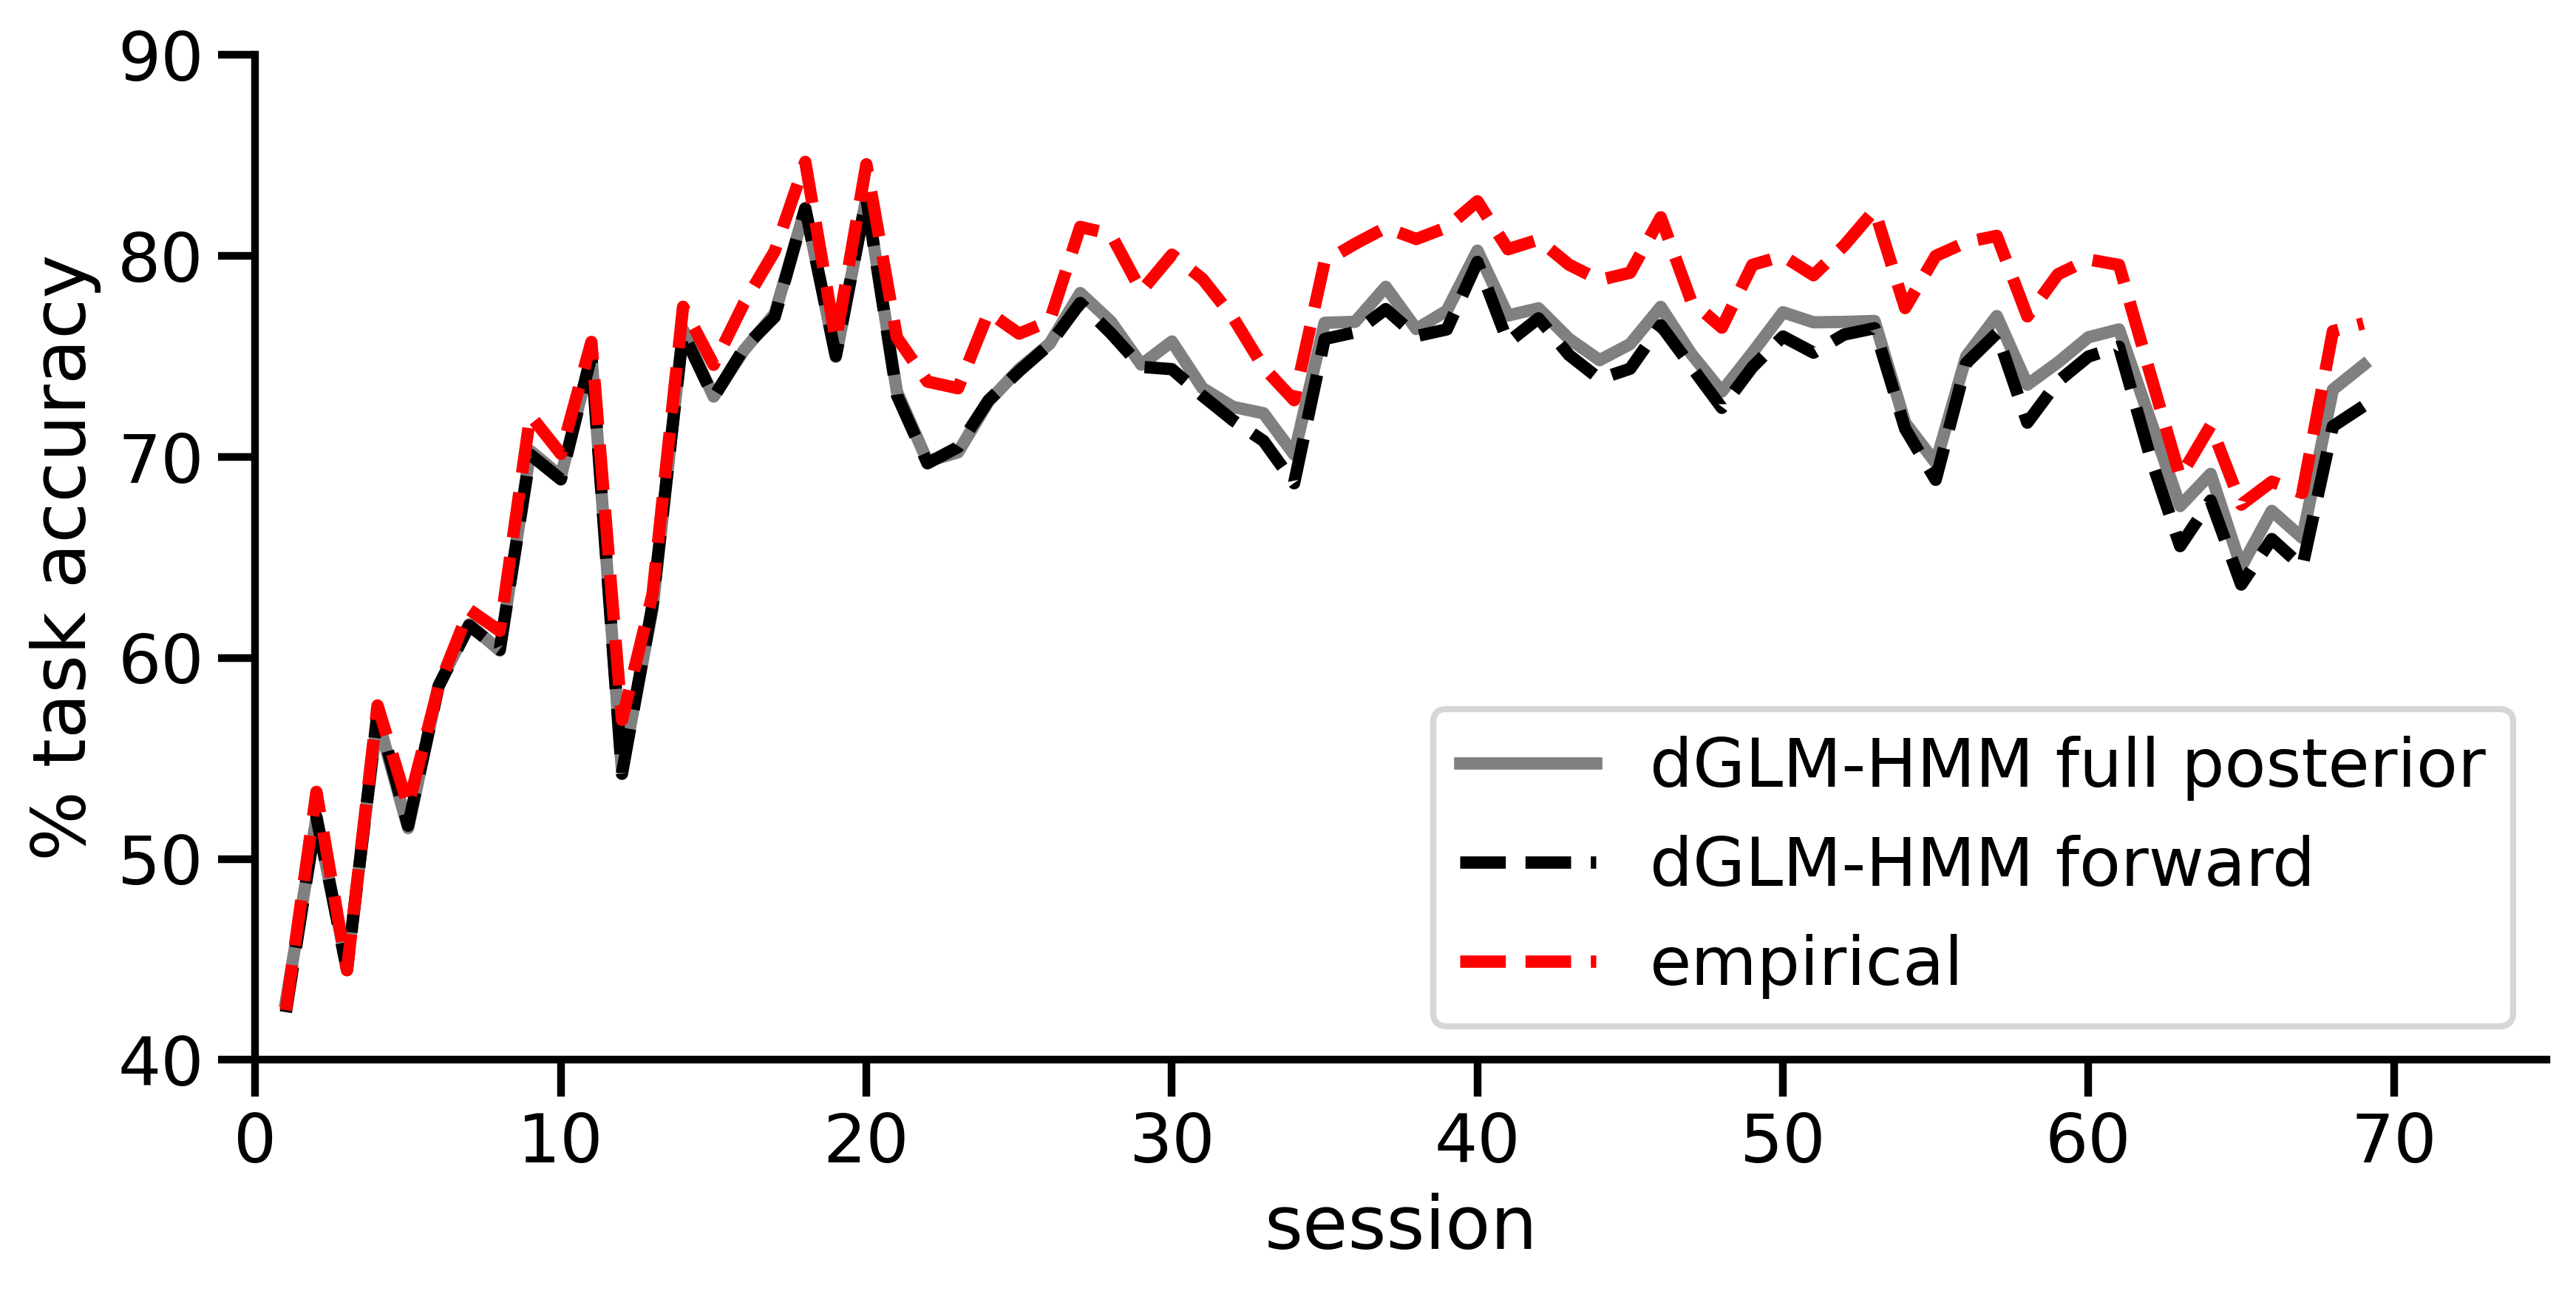

In [16]:
# empirical vs mixture vs model (full posterior latents) vs model (forward latents)
_, _, p_correct_sessions_full, p_correct_states_sessions_full = accuracy_states_sessions(gamma, phi, y, correctSide, sessInd)
# _, _, p_correct_sessions_old, p_correct_states_sessions_old = accuracy_states_sessions(gamma_old, phi, y, correctSide, sessInd)
_, _, p_correct_sessions_forward, p_correct_states_sessions_forward = accuracy_states_sessions(alpha, phi, y, correctSide, sessInd)
_, performance_psytrack = IBL_performance(dfAll, subject, plot=False)

maxSess = len(sessInd)-1
fig, axes = plt.subplots(1, figsize = (10,4.5), dpi=400) 
# dGLM-HMM overall accuracy
# axes.fill_between(range(1,maxSess+1), np.nanmean(arrOverallCorrect, axis=1)-np.nanstd(arrOverallCorrect, axis=1), np.nanmean(arrOverallCorrect, axis=1)+np.nanstd(arrOverallCorrect, axis=1), alpha=0.2, zorder=0, color="black")
# axes.plot(range(1,maxSess+1), p_correct_sessions_old, color="gray", linewidth=3, label='dGLM-HMM1', zorder=1)
axes.plot(range(1,maxSess+1), p_correct_sessions_full, color="gray", linewidth=3, label='dGLM-HMM full posterior', zorder=1)
axes.plot(range(1,maxSess+1), p_correct_sessions_forward, color="black", linewidth=3, label='dGLM-HMM forward', zorder=1, ls='dashed')


# # Mixture overall accuracy
# # axes.fill_between(range(1,maxSess+1), np.nanmean(arrOverallMixtureCorrect, axis=1)-np.nanstd(arrOverallMixtureCorrect, axis=1), np.nanmean(arrOverallMixtureCorrect, axis=1)+np.nanstd(arrOverallMixtureCorrect, axis=1), alpha=0.2, zorder=0, color="gray")
# axes.plot(range(1,maxSess+1), np.nanmean(arrOverallMixtureCorrect, axis=1), color="gray", linewidth=3, label='mixture', zorder=1)

# empirical accuracy
# axes.fill_between(range(1,maxSess+1), np.nanmean(arrEmpiricalCorrect, axis=1)-np.nanstd(arrEmpiricalCorrect, axis=1), np.nanmean(arrEmpiricalCorrect, axis=1)+np.nanstd(arrEmpiricalCorrect, axis=1), alpha=0.2, zorder=0, color="red")
# axes.plot(range(1,maxSess+1), performance_psytrack[:-1]*100, color="red", linewidth=3, label='empirical old', zorder=1)
axes.plot(range(1,maxSess+1), performance_recompute, color="red", linewidth=3, label='empirical', zorder=1, ls='dashed')


axes.set_ylabel('% task accuracy')
axes.set_xlabel('session')
# axes.set_yticks([40,60,80])
axes.set_ylim(40,90)
axes.set_xlim(0,75)
axes.axhline(0.5, color="black", linestyle="--", lw=1, alpha=0.3, zorder=0)
axes.spines[['right', 'top']].set_visible(False)
axes.legend(loc='lower right')
# axes.set_title('Model vs Empirical Performance' ,size=22, pad=20)
# plt.savefig(f'../figures/Accuracy_Model-Empirical-Mixture_allAnimals', bbox_inches='tight', dpi=400)





In [17]:
sessionsInterest = [6,16,26,61] #[56,57,59,60,61,62,66] - beautiful psychometrics # 15 or 16

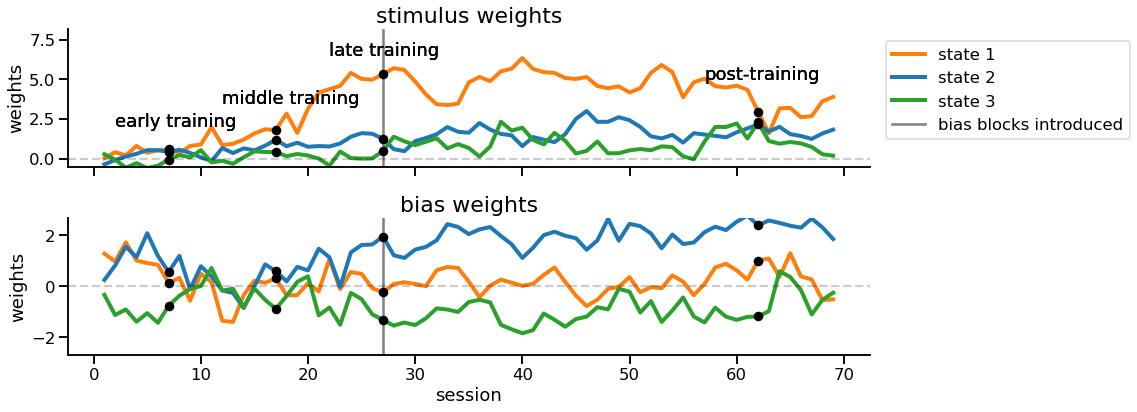

In [18]:
plotSess = len(sessInd)-1 #min(len(sessInd)-1)#,50)
fig, axes = plt.subplots(2, 1,figsize=(13,6), sharex=True)#, dpi=400)
fig.tight_layout(pad=2)
yLim=[[-2.7,2.7],[-0.5,8.2],[-2.7,2.7],[-2.7,2.7]]
yText = [[2,3.5,6.5,5]]
sessionTitle = ['early training','middle training','late training','post-training']
for d in range(0, 2):
    axes[d].axhline(0, alpha=0.2, color='black',linestyle='--')
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),-allW[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=4, alpha=1, label=f'state {k+1}', linestyle='-', zorder=0)
        for s in range(0,len(sessionsInterest)):
            axes[d].scatter(sessionsInterest[s]+1, -allW[sessInd[sessionsInterest[s]],k,1-d,1], color='black', zorder=2, s=65)
            if (d==0):
                axes[d].text(sessionsInterest[s]-4, yText[d][s], sessionTitle[s])
    axes[d].set_ylim(yLim[1-d])
    # axes[d].set_title(f'{myFeatures[D%2][d]}')
    axes[d].set_ylabel(f'weights')
    axes[d].set_title(f'{myFeatures[D%2][1-d]} weights', size=22)
    axes[d].spines[['right', 'top']].set_visible(False)
    axes[d].axvline(firstBlockSession+1, color='gray',zorder=0, alpha=1, linewidth=2.5, label='bias blocks introduced')
    axes[0].legend(loc=(1.02,0.2))
axes[1].set_xlabel('session')
plt.savefig(f'../figures/weights_fig4_{subject}', bbox_inches='tight', dpi=400)

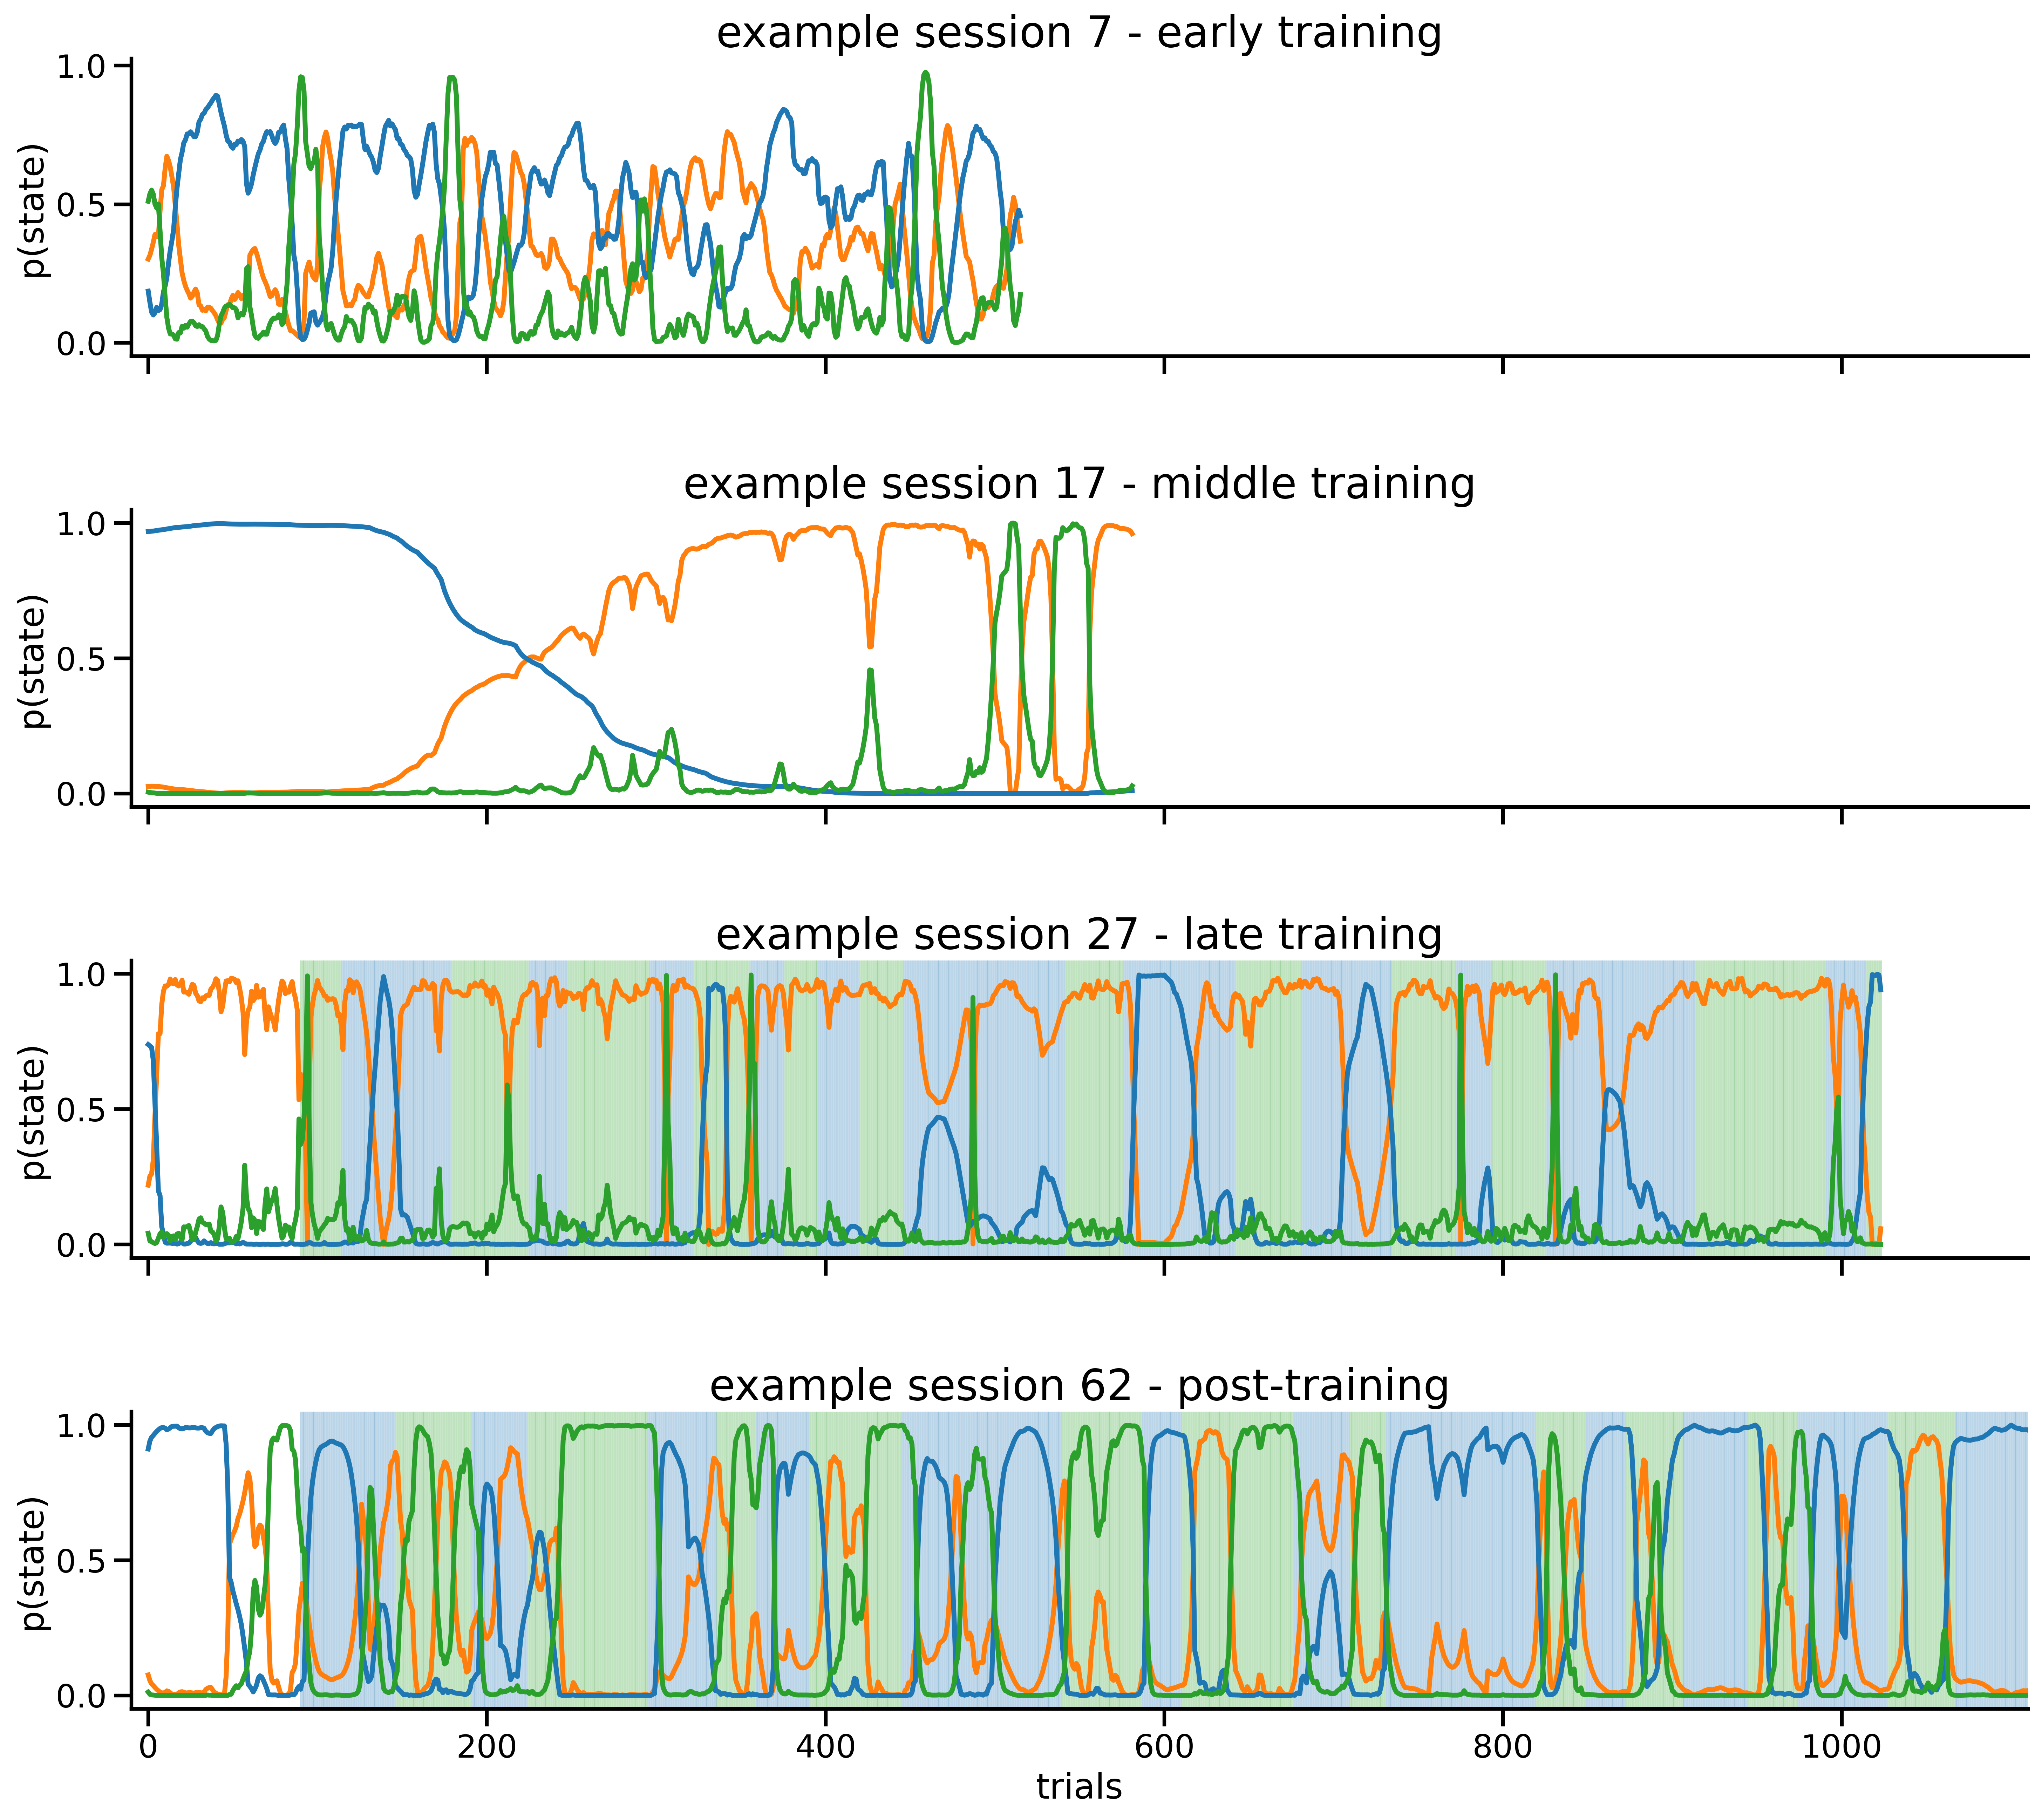

In [20]:
fig, axes = plt.subplots(len(sessionsInterest), 1, figsize=(16,14), dpi=400, sharex=True)
fig.tight_layout(pad=3.5)
plot_posteior_latent(gamma, sessInd, axes, sessions = sessionsInterest, linewidth=2.5)
for s in range(0,len(sessionsInterest)):
    sess = sessionsInterest[s]
    for t in range(sessInd[sess],sessInd[sess+1]):
        if (biasedBlockTrials[t] == 1):
            axes[s].axvline(t-sessInd[sess], color='tab:blue', label='right block', zorder=0, alpha=0.3, linewidth=0.85)
        elif (biasedBlockTrials[t] == -1):
            axes[s].axvline(t-sessInd[sess], color='tab:green', label='left block', zorder=0, alpha=0.3, linewidth=0.85)
    axes[s].set_xlim(-10,1110)
    axes[s].set_title(f'example session {sessionsInterest[s]+1} - {sessionTitle[s]}', size=22)
    axes[s].spines[['right', 'top']].set_visible(False)
    axes[s].get_legend().remove()
    axes[s].set_ylabel('p(state)')
plt.savefig(f'../figures/posterior_latent_example-sessions_{subject}', bbox_inches='tight', dpi=400)


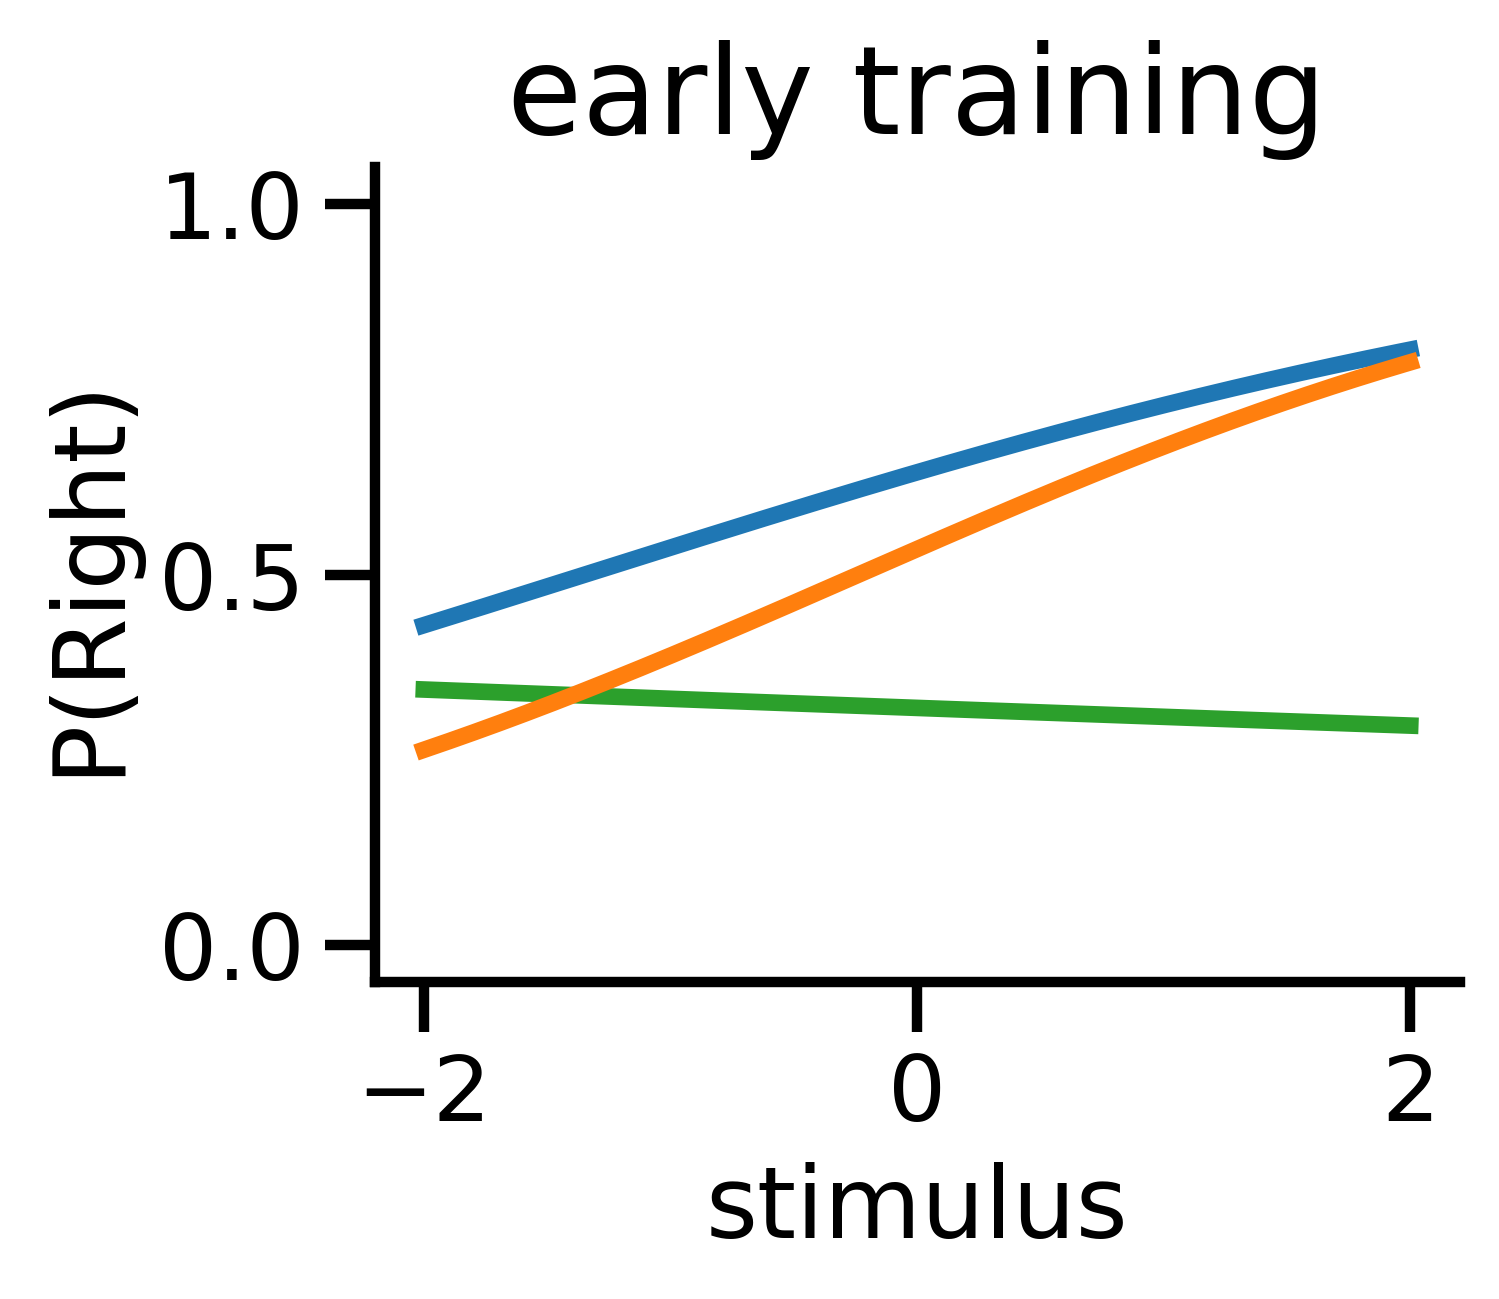

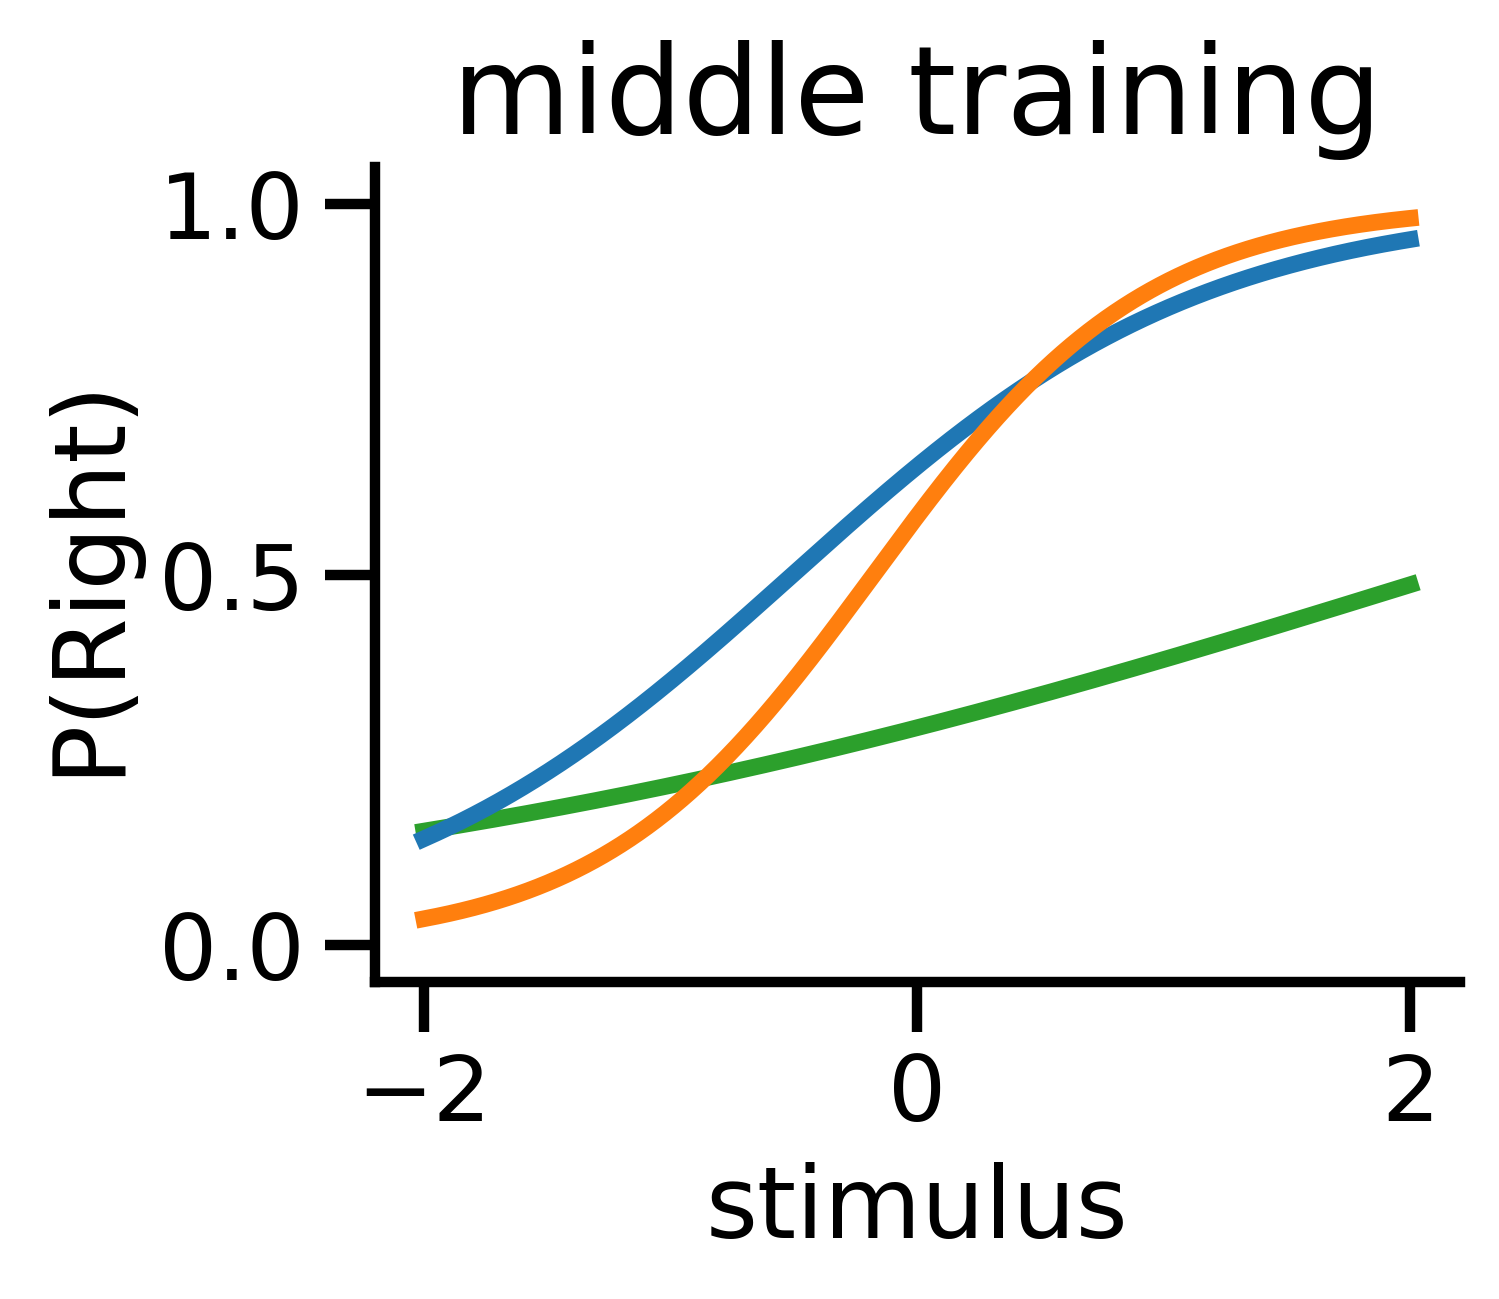

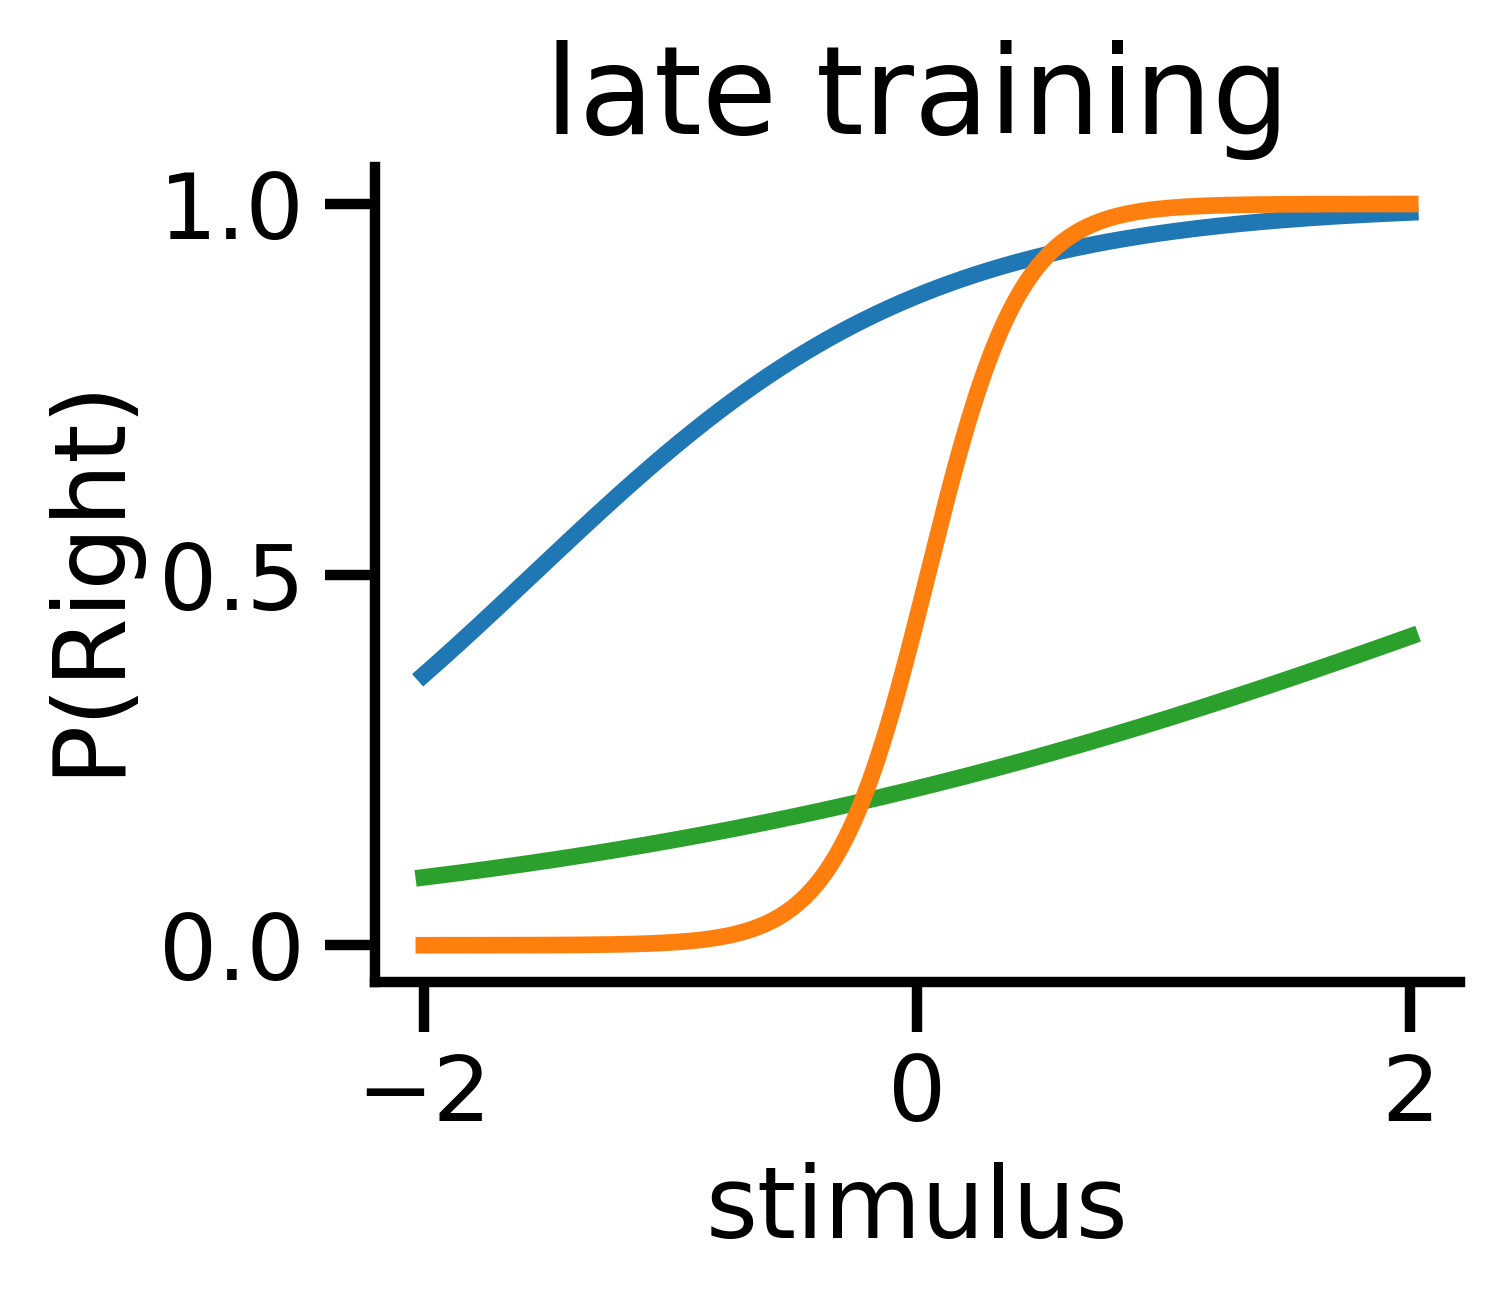

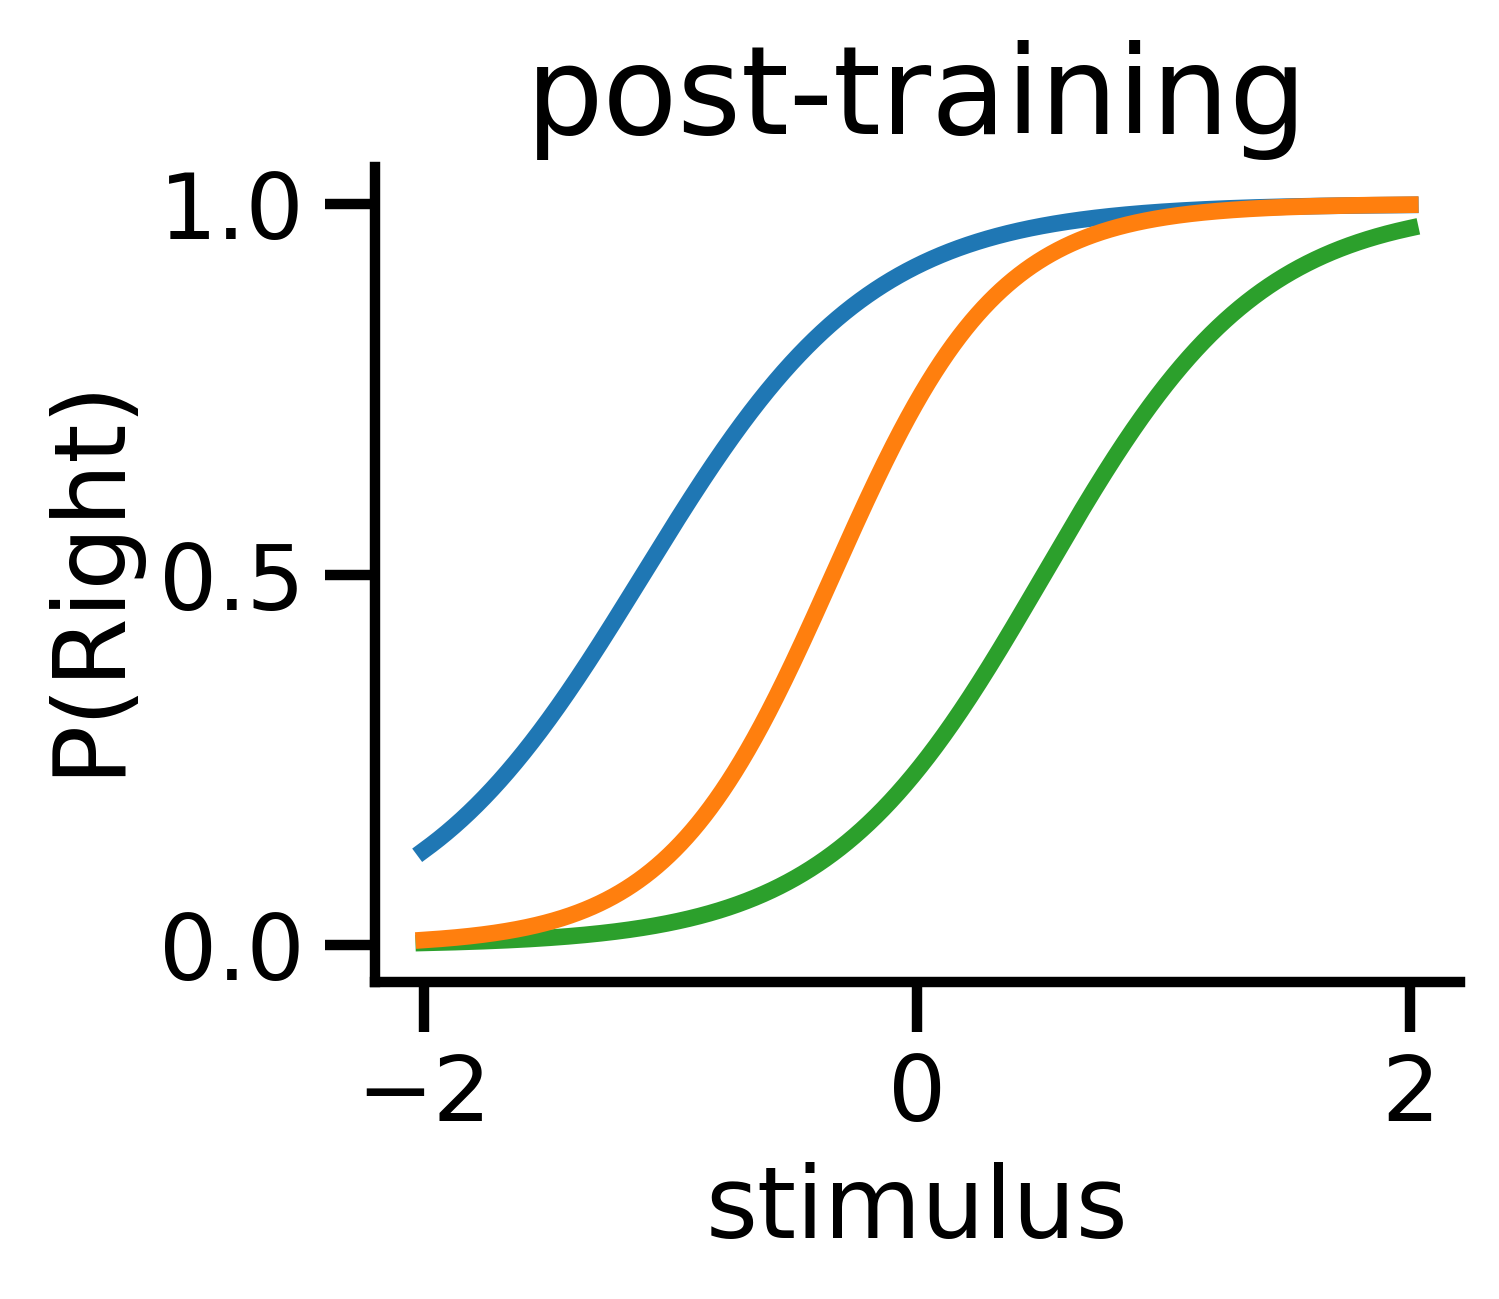

In [45]:
for s in range(0,len(sessionsInterest)):
    fig, axes = plt.subplots(figsize=(3.5,2.7), dpi=400)
    plotting_psychometric(w=-allW, sessInd=sessInd, session=sessionsInterest[s], axes=axes, colorsStates=colorsStates)
    axes.set_title(f'{sessionTitle[s]}', size=22)#(f'example session - {sessionTitle[s]}', size=22)
    axes.spines[['right', 'top']].set_visible(False)
    axes.get_legend().remove()
    plt.savefig(f'../figures/psychometric{s}_{subject}', bbox_inches='tight', dpi=400)


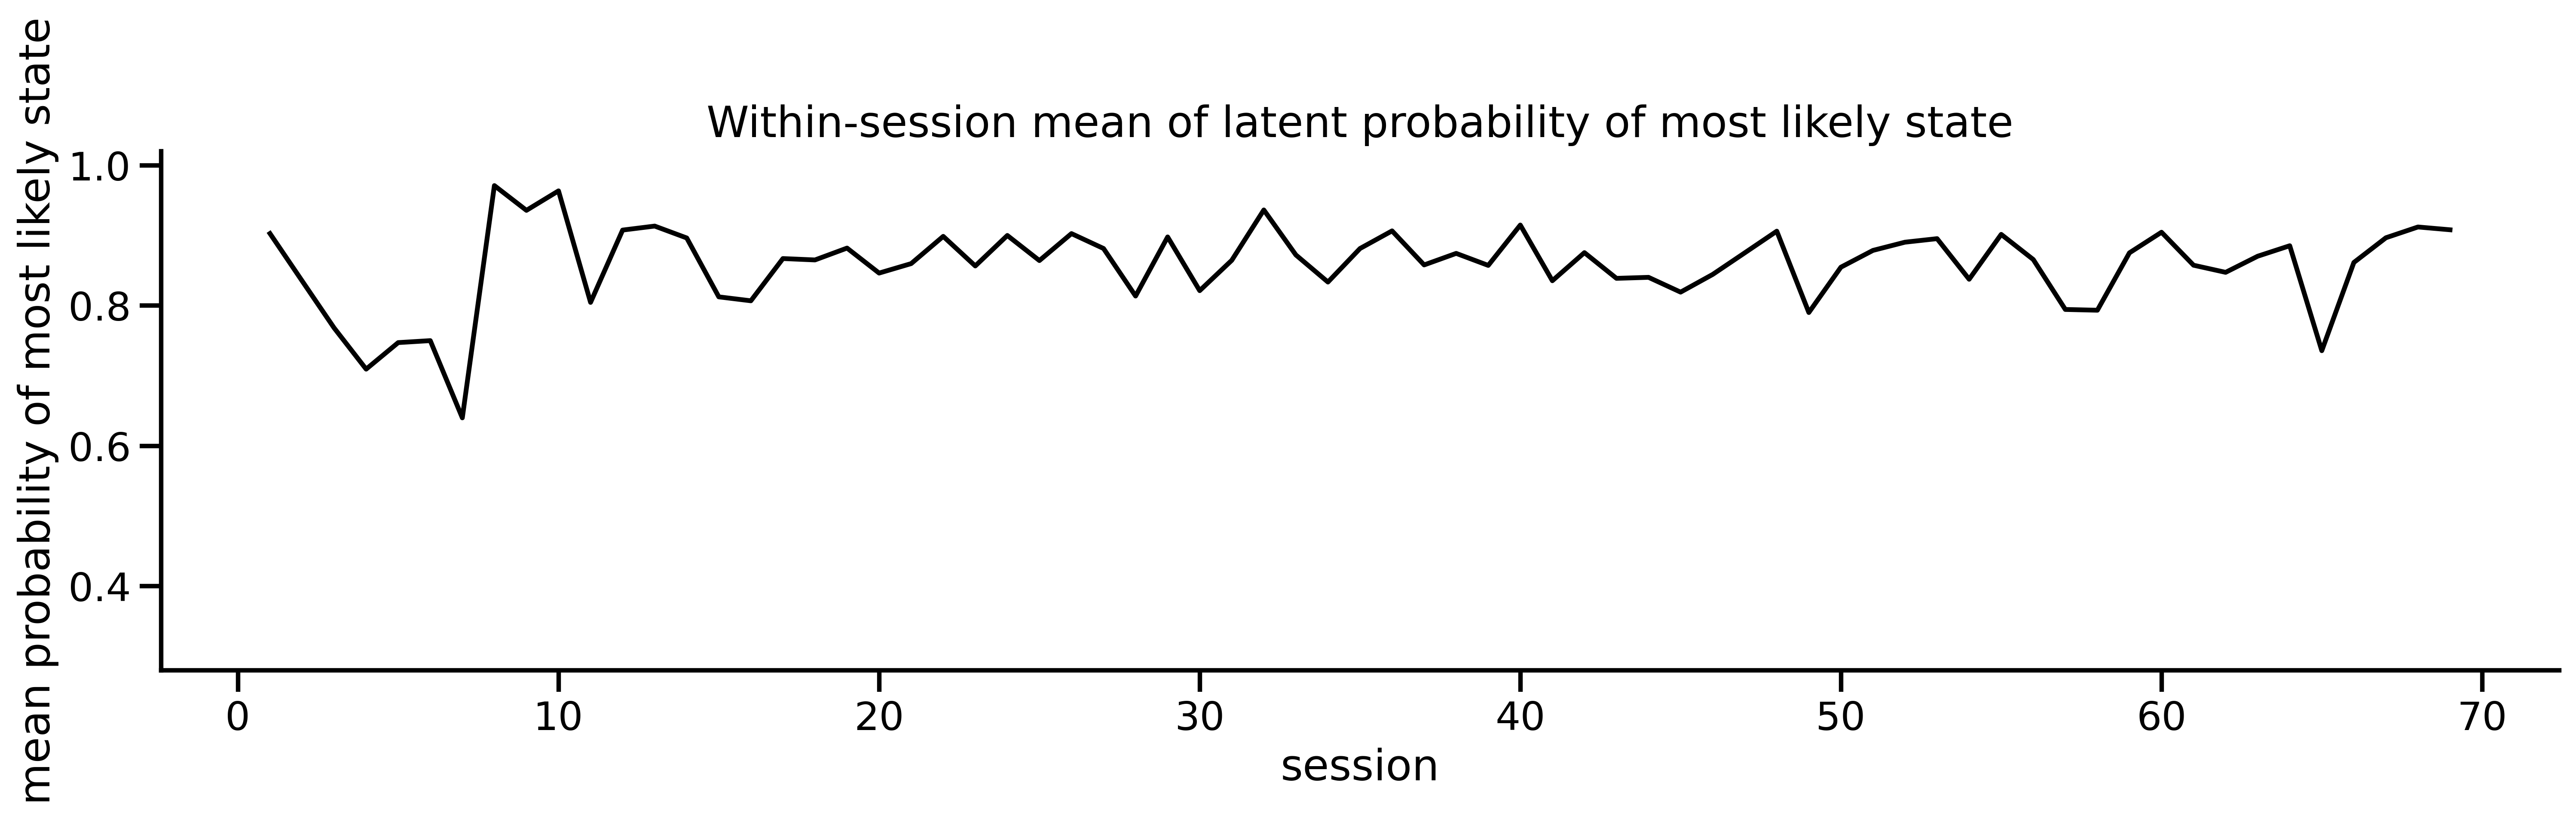

In [47]:
fig, axes = plt.subplots(1, figsize=(18,4), dpi=400)
axes.spines[['right', 'top']].set_visible(False)
axes.set_xlabel('session')
axes.set_ylabel('mean probability of most likely state')
axes.set_ylim(0.28,1.02)
axes.set_title('Within-session mean of latent probability of most likely state')
probMaxSession = distribution_most_likely_state(gamma, sessInd, axes)
plt.savefig(f'../figures/latent_most-likely-state_{subject}', bbox_inches='tight', dpi=400)